# 480 gages pre-trained LSTM model

### 7/16/2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math, keras, random
from keras import layers, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from statsmodels.tsa.api import SimpleExpSmoothing
from keras.callbacks import EarlyStopping
from datetime import datetime
import hydroeval as he
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-04-23 11:56:56.324771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 11:56:56.457618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 11:56:56.539871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 11:56:56.576703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 11:56:56.640885: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os

# Back out one directory to project folder
PROJECT_DIR = os.path.dirname(os.path.abspath(''))
os.chdir(PROJECT_DIR)

# Set directories
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIGURE_DIR = os.path.join(PROJECT_DIR, 'outputs','figures')
OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
CONFIG_DIR = os.path.join(PROJECT_DIR, "config")

# Setup logging
from src.utils.logging_setup import setup_logging
logger = setup_logging(log_dir='logs', log_filename="FP_TL_LSTM.log")

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1745423823.788150  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745423824.032172  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745423824.032274  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Read in data, drop unnecessary variables, scale data, and split into X and y

In [4]:
from scripts.data_preprocessing import river_pipeline, floodplain_pipeline
river_dict = river_pipeline("3")
floodplain_dict = floodplain_pipeline("4")

['lat', 'FUNGICIDE', 'ELEV_MEAN', 'LAKEPOND', 'N97', 'CNPY11_BUFF100', 'BASIN_AREA', 'NLCD01_52', 'ELEV_MAX', 'dayl (s)', 'HGAD', 'prcp (mm/day)', 'STRM_DENS', 'WDANN', 'q', 'o', 'NLCD01_81', 'ELEV_MIN', 'HGC', 'CONTACT', 'BEDPERM_6', 'RH', 'swe (kg/m2)', 'NLCD01_95', 'tmin (degrees C)', 'BFI', 'srad (W/m2)', 'SALINAVE', 'ARTIFICIAL', 'SANDAVE', 'sinuosity', 'temp', 'vp (Pa)', 'tmax (degrees C)', 'SILTAVE', 'lon']
['lat', 'FUNGICIDE', 'ELEV_MEAN', 'LAKEPOND', 'N97', 'CNPY11_BUFF100', 'BASIN_AREA', 'NLCD01_52', 'ELEV_MAX', 'dayl (s)', 'HGAD', 'prcp (mm/day)', 'STRM_DENS', 'WDANN', 'q', 'o', 'NLCD01_81', 'ELEV_MIN', 'HGC', 'CONTACT', 'BEDPERM_6', 'RH', 'swe (kg/m2)', 'NLCD01_95', 'tmin (degrees C)', 'BFI', 'srad (W/m2)', 'SALINAVE', 'ARTIFICIAL', 'SANDAVE', 'sinuosity', 'temp', 'vp (Pa)', 'tmax (degrees C)', 'SILTAVE', 'lon']
960721
413438
['lat', 'FUNGICIDE', 'ELEV_MEAN', 'LAKEPOND', 'N97', 'CNPY11_BUFF100', 'BASIN_AREA', 'NLCD01_52', 'ELEV_MAX', 'dayl (s)', 'HGAD', 'prcp (mm/day)', 'ST

In [5]:
# Extract necessary data from floodplain data dictionary
# Get master (i.e., concatenated across all sites) data 
X_train_FP = floodplain_dict['master']['X_train_fp']
y_train_FP = floodplain_dict['master']['y_train_fp']
X_test_FP= floodplain_dict['master']['X_test_fp']
y_test_FP = floodplain_dict['master']['y_test_fp']
train_gen_FP = floodplain_dict['master']['train_gen_fp']
test_gen_FP = floodplain_dict['master']['test_gen_fp']
steps_per_epoch_FP = floodplain_dict['master']['steps_per_epoch_fp']
val_steps_FP = floodplain_dict['master']['val_steps_fp']
X_FP_rs = floodplain_dict['master']['X_master_rs']
y_FP_rs = floodplain_dict['master']['y_master_rs']

# Get site level data
# OC2
OC2_noNA = floodplain_dict['OC2']['OC2_noNA']
X_OC2 = floodplain_dict['OC2']['X_OC2']
y_OC2 = floodplain_dict['OC2']['y_OC2']
OC2_start_ind = floodplain_dict['OC2']['OC2_start']
OC2_end_ind = floodplain_dict['OC2']['OC2_end']
# LF1
LF1_noNA = floodplain_dict['LF1']['LF1_noNA']
X_LF1 = floodplain_dict['LF1']['X_LF1']
y_LF1 = floodplain_dict['LF1']['y_LF1']
LF1_start_ind = floodplain_dict['LF1']['LF1_start']
LF1_end_ind = floodplain_dict['LF1']['LF1_end']
# LF2
LF2_noNA = floodplain_dict['LF2']['LF2_noNA']
X_LF2 = floodplain_dict['LF2']['X_LF2']
y_LF2 = floodplain_dict['LF2']['y_LF2']
LF2_start_ind = floodplain_dict['LF2']['LF2_start']
LF2_end_ind = floodplain_dict['LF2']['LF2_end']
# OC4
OC4_noNA = floodplain_dict['OC4']['OC4_noNA']
X_OC4 = floodplain_dict['OC4']['X_OC4']
y_OC4 = floodplain_dict['OC4']['y_OC4']
OC4_start_ind = floodplain_dict['OC4']['OC4_start']
OC4_end_ind = floodplain_dict['OC4']['OC4_end']
# LF3
LF3_noNA = floodplain_dict['LF3']['LF3_noNA']
X_LF3 = floodplain_dict['LF3']['X_LF3']
y_LF3 = floodplain_dict['LF3']['y_LF3']
LF3_start_ind = floodplain_dict['LF3']['LF3_start']
LF3_end_ind = floodplain_dict['LF3']['LF3_end']
# OC1
OC1_noNA = floodplain_dict['OC1']['OC1_noNA']
X_OC1 = floodplain_dict['OC1']['X_OC1']
y_OC1 = floodplain_dict['OC1']['y_OC1'] 
OC1_start_ind = floodplain_dict['OC1']['OC1_start']
OC1_end_ind = floodplain_dict['OC1']['OC1_end']
# OC3
OC3_noNA = floodplain_dict['OC3']['OC3_noNA']
X_OC3 = floodplain_dict['OC3']['X_OC3']
y_OC3 = floodplain_dict['OC3']['y_OC3']
OC3_start_ind = floodplain_dict['OC3']['OC3_start']
OC3_end_ind = floodplain_dict['OC3']['OC3_end']

In [6]:
# Extract necessary data from river dictionary
data_sc_noNA = river_dict['scaled_df']
data_sc_train = river_dict['train_df']
data_sc_test = river_dict['test_df']
riv_data_site_inds = river_dict['split_inds']
X_train = river_dict['X_train']
X_test = river_dict['X_test']
y_train = river_dict['y_train']
y_test = river_dict['y_test']
train_gen = river_dict['train_gen']
test_gen = river_dict['test_gen']
steps_per_epoch = river_dict['steps_per_epoch']
val_steps = river_dict['val_steps']

In [7]:
print(len(X_train)); print(len(X_test)); print(len(y_train)); print(len(y_test))

1086918
465543
1086918
465543


In [8]:
print(len(X_train.columns))

35


#### Hyperparameters

In [9]:
import yaml
CONFIG_DIR = os.path.join(PROJECT_DIR, 'config')
with open(os.path.join(CONFIG_DIR, 'river_lstm3_config.yaml'), 'r') as f:
    config = yaml.safe_load(f)
    
seed = config['seed']
split_pct = config['split_pct']
window_length = config['window_length']
hidden_layers = config['hidden_layers']
hidden_units = config['hidden_units']
batch_size = config['batch_size']
n_epochs = config['n_epochs']
activation_dense = config['activation_dense']
learning_rate = config['learning_rate']
dropout = config['dropout']
stop_patience = config['stop_patience']
lr_schedule_patience = config['lr_schedule_patience']

In [10]:
from src.utils import model_building_training_functions as mbf

# Build the model
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train.columns)
# n_features = 27
model = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
# Uncomment if model has already been trained
model.load_weights(MODEL_DIR + '/River_LSTM.weights.h5')

I0000 00:00:1745424031.339221  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745424031.339454  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745424031.339509  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745424031.725136  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745424031.725429  805369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-23

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8)              │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417 (5.54 KB)

 Trainable params: 1,417 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

/home/ghmyers/miniconda3/envs/TF_GPU/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
# keras.utils.set_random_seed(seed)
# model_name = 'River_LSTM'
# earlyStopping = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=lr_schedule_patience, min_lr=0.0000001, verbose=1)
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(PROJECT_DIR,'models', f'{model_name}.weights.h5'), save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

# callbacks = [earlyStopping, lr_scheduler, checkpoint_callback]
# history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, batch_size=batch_size, 
#                     epochs=n_epochs, verbose=1, validation_data=test_gen, 
#                     validation_steps=val_steps, callbacks=callbacks)
# logger.info(f'Model ({model_name}) parameters:')
# logger.info(f'Seed: {seed}')
# logger.info(f'Activation: {activation_dense}')
# logger.info(f'Split Percentage: {split_pct}')
# logger.info(f'Hidden LSTM layers: {hidden_layers}')
# logger.info(f'Hidden units: {hidden_units}')
# logger.info(f'Window length: {window_length}')
# logger.info(f'Batch size: {batch_size}')
# logger.info(f'Learning rate: {learning_rate}')
# logger.info(f'Dropout: {dropout}')
# logger.info(f'Epochs: {n_epochs}')
# logger.info(f'Stop patience: {stop_patience}')
# logger.info(f"Learning rate scheduler patience: {lr_schedule_patience}")
# logger.info("Custom loss function: None")
# logger.info(f"Model loss: {history.history['loss']}")
# logger.info(f"Validation loss: {history.history['val_loss']}")

In [12]:
# logger.info("Model training ended early due to inadequate performance. Model weights not saved.")
# logger.info("Model trained until completion. Final val loss 0.0045. Model started to overfit around epoch 55.")

In [13]:
# plt.figure(figsize=(6,4), dpi=400)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('River LSTM Model Loss')
# plt.ylabel('Loss (MSE)')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# # plt.savefig(os.path.join(FIGURE_DIR, 'river_LSTM_loss.png'))
# plt.show()

### Test river LSTM on river data

In [14]:
# river_preds = model.predict(test_gen, steps=val_steps)
# def extract_true_values(generator, steps):
#     y_batches = []

#     for step, (X_batch, y_batch) in enumerate(generator):
#         if step >= steps:  # Stop after val_steps steps
#             break
#         y_batches.append(y_batch)

#     # Combine all batches into a single array or tensor
#     y_true = tf.concat(y_batches, axis=0)
#     return y_true

# y_true = extract_true_values(test_gen, val_steps)

In [15]:
# print(len(river_preds), len(y_true))

In [16]:
# assert len(y_true) == len(river_preds), "Lengths not equal"
# # print(len(y_true), len(river_preds))

In [17]:
import joblib
scaler_y = joblib.load(os.path.join(MODEL_DIR, 'y_scaler.pkl'))
scaler = joblib.load(os.path.join(MODEL_DIR, 'scaler.pkl'))

/home/ghmyers/miniconda3/envs/TF_GPU/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
# def evaluate_river_predictions(y_true, y_preds, scaler_y):
#     # Convert to 1-D arrays and inverse tranform
#     y_true -= 1e-7
#     y_preds -= 1e-7
    
#     # Rescale data to original scale
#     actual = scaler_y.inverse_transform(np.array(y_true).flatten().reshape(-1, 1))
#     predictions = scaler_y.inverse_transform(np.array(y_preds).flatten().reshape(-1, 1))
    
#     plt.hist(actual)
#     plt.title("Distribution of DO in Testing Data")
#     plt.show()
#     plt.hist(predictions)
#     plt.title("Distribution of DO Predictions")
#     plt.show()
    
#     rmse = math.sqrt(mean_squared_error(actual, predictions))
#     r2 = r2_score(actual, predictions)
#     kge = he.evaluator(he.kge, actual, predictions)
#     bias = he.evaluator(he.pbias, actual, predictions)
#     performance_metrics = {"RMSE": round(rmse, 3),
#                             'KGE': round(kge[0][0], 3),
#                             f"R{chr(0x00B2)}": round(r2, 3),
#                             'Bias': round(bias[0], 3)}
#     return performance_metrics



# river_model_performance = evaluate_river_predictions(y_true, river_preds, scaler_y)
# # print(river_model_performance)
# # logger.info(river_model_performance)

### Fine-tune model to floodplain data

In [19]:
with open(os.path.join(CONFIG_DIR, "TL_lstm4_config.yaml"), "r") as f:
    config = yaml.safe_load(f)

# Set hyperparameters from config file
seed = config['seed']
split_pct = config['split_pct']
window_length = config['window_length']
hidden_layers = config['hidden_layers']
hidden_units = config['hidden_units']
batch_size = config['batch_size']
n_epochs = config['n_epochs']
activation_dense = config['activation_dense']
learning_rate = config['learning_rate']
dropout = config['dropout']
stop_patience = config['stop_patience']
lr_schedule_patience = config['lr_schedule_patience']


In [20]:
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train_FP.columns)
model_FT = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)

# model_FT.load_weights(PROJECT_DIR + '/models/old/River_LSTM.weights.h5')
model_FT.load_weights(MODEL_DIR + '/TL_LSTM.weights.h5')

# Uncomment if model has already been trained
# model_FT.load_weights(PROJECT_DIR+ '/models/TL_LSTM_v1.weights.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8)              │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417 (5.54 KB)

 Trainable params: 1,417 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# model_name_FT = "TL_LSTM_v4_oldFeatures_WL2"

# keras.utils.set_random_seed(seed)
# earlyStopping_FT = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=lr_schedule_patience, min_lr=0.0000001, verbose=1)
# checkpoint_callback_FT = tf.keras.callbacks.ModelCheckpoint(filepath=PROJECT_DIR + f'/models/{model_name_FT}.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

# callbacks_FT = [earlyStopping_FT, lr_scheduler, checkpoint_callback_FT]
# history_FT = model_FT.fit(train_gen_FP, steps_per_epoch=steps_per_epoch_FP, batch_size=batch_size, 
#                     epochs=n_epochs, verbose=1, validation_data=test_gen_FP, 
#                     validation_steps=val_steps_FP, callbacks=callbacks_FT)

# logger.info(f'Model ({model_name_FT}) parameters:')
# logger.info(f'Seed: {seed}')
# logger.info(f'Activation: {activation_dense}')
# logger.info(f'Split Percentage: {split_pct}')
# logger.info(f'Hidden LSTM layers: {hidden_layers}')
# logger.info(f'Hidden units: {hidden_units}')
# logger.info(f'Window length: {window_length}')
# logger.info(f'Batch size: {batch_size}')
# logger.info(f'Learning rate: {learning_rate}')
# logger.info(f'Dropout: {dropout}')
# logger.info(f'Epochs: {n_epochs}')
# logger.info(f'Stop patience: {stop_patience}')
# logger.info(f"Learning rate scheduler patience: {lr_schedule_patience}")
# logger.info("Custom loss function: None")
# logger.info(f"Model loss: {history_FT.history['loss']}")
# logger.info(f"Validation loss: {history_FT.history['val_loss']}")

In [22]:
# plt.figure(figsize=(6,4), dpi=300)
# plt.plot(history_FT.history['loss'])
# plt.plot(history_FT.history['val_loss'])
# plt.title('TL-LSTM Model Loss')
# plt.ylabel('Loss (MSE)')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.tight_layout()
# # plt.savefig(FIGURE_DIR + '/TL_LSTM_v4_oldFeatures_loss.png', dpi=300)
# plt.show()

### Make predictions at individual sites

In [23]:
OC2_start = OC2_noNA.index.get_loc(OC2_start_ind); OC2_end = OC2_noNA.index.get_loc(OC2_end_ind)
LF1_start = LF1_noNA.index.get_loc(LF1_start_ind); LF1_end = LF1_noNA.index.get_loc(LF1_end_ind)
LF2_start = LF2_noNA.index.get_loc(LF2_start_ind); LF2_end = LF2_noNA.index.get_loc(LF2_end_ind)
OC4_start = OC4_noNA.index.get_loc(OC4_start_ind); OC4_end = OC4_noNA.index.get_loc(OC4_end_ind)
LF3_start = LF3_noNA.index.get_loc(LF3_start_ind); LF3_end = LF3_noNA.index.get_loc(LF3_end_ind)
OC1_start = OC1_noNA.index.get_loc(OC1_start_ind); OC1_end = OC1_noNA.index.get_loc(OC1_end_ind)
OC3_start = OC3_noNA.index.get_loc(OC3_start_ind); OC3_end = OC3_noNA.index.get_loc(OC3_end_ind)

In [24]:
OC2_preds = model_FT.predict(X_OC2, batch_size=batch_size)
LF1_preds = model_FT.predict(X_LF1, batch_size=batch_size)
LF2_preds = model_FT.predict(X_LF2, batch_size=batch_size)
OC4_preds = model_FT.predict(X_OC4, batch_size=batch_size)
LF3_preds = model_FT.predict(X_LF3, batch_size=batch_size)
OC1_preds = model_FT.predict(X_OC1, batch_size=batch_size)
OC3_preds = model_FT.predict(X_OC3, batch_size=batch_size)

  1/223 ━━━━━━━━━━━━━━━━━━━━ 1:58 534ms/step

2025-04-23 12:00:34.839630: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Plot predictions

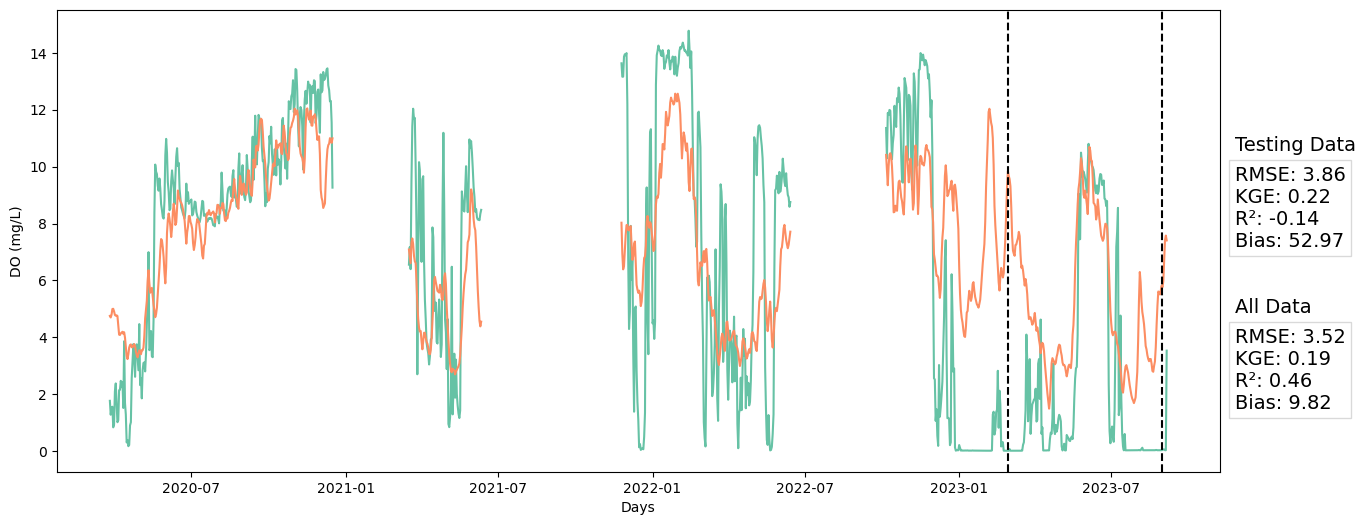

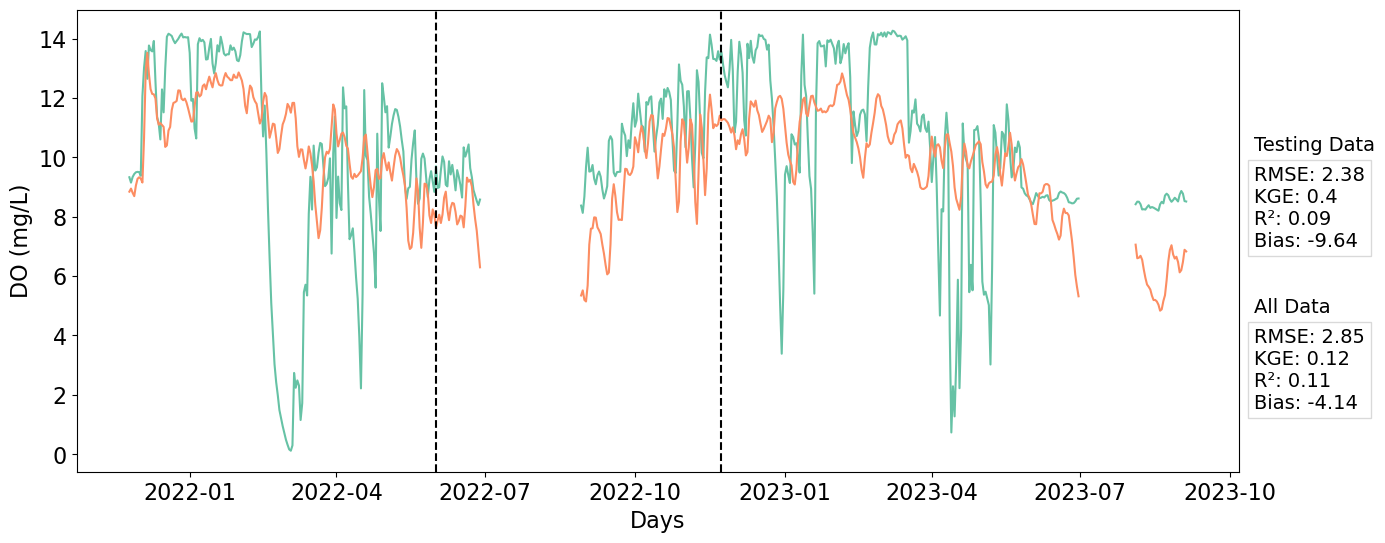

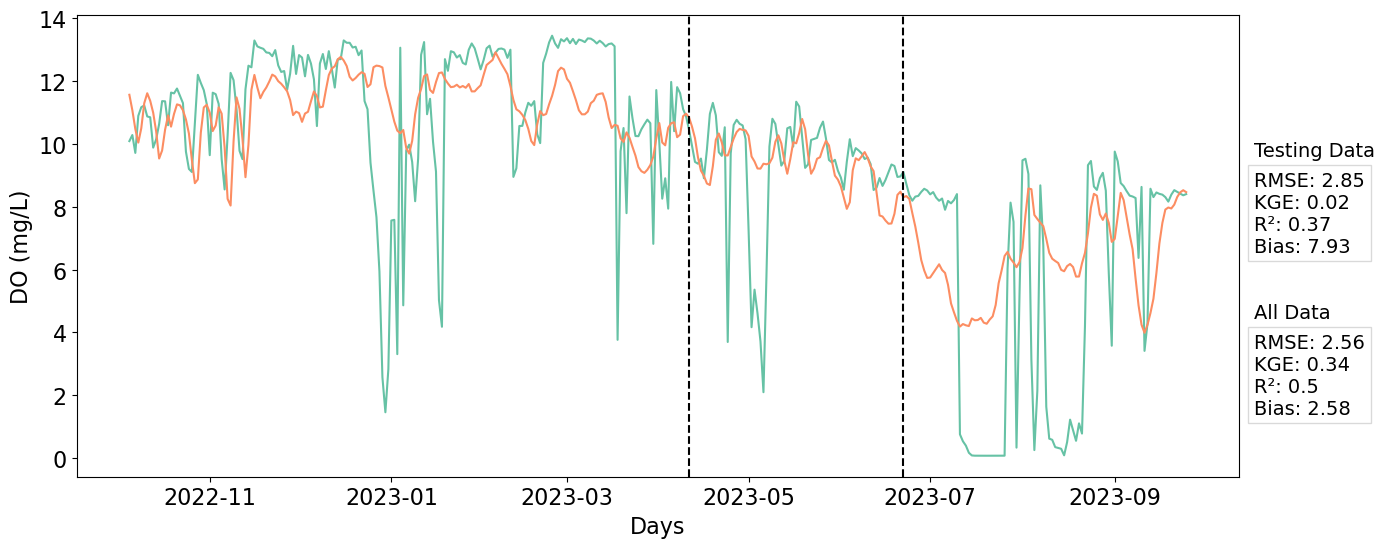

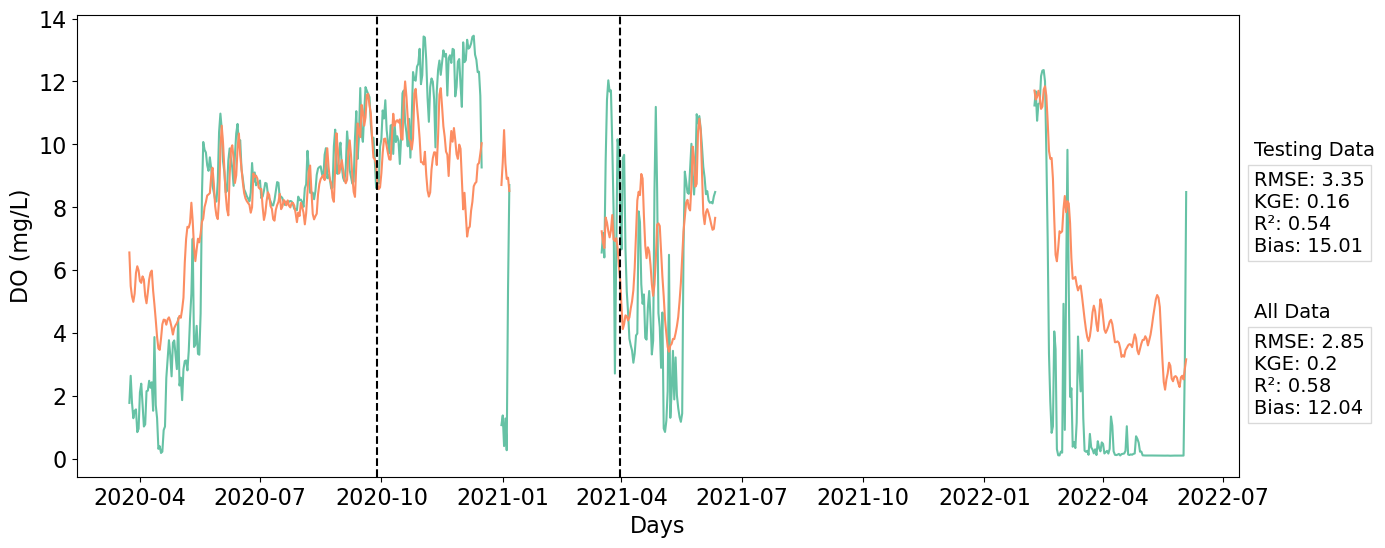

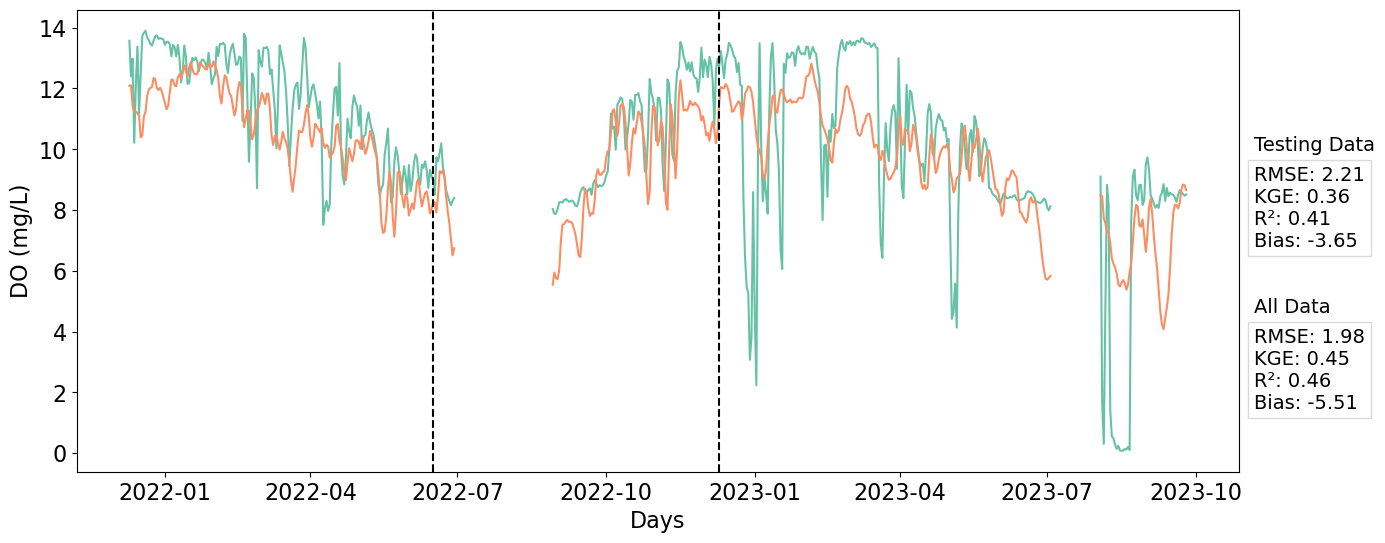

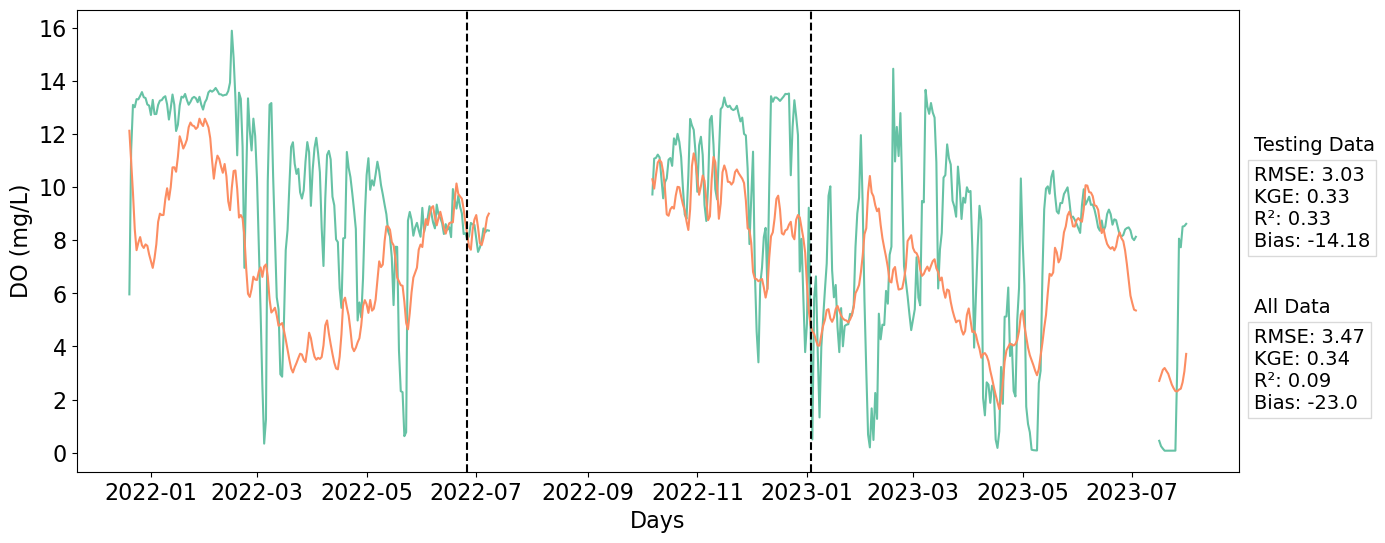

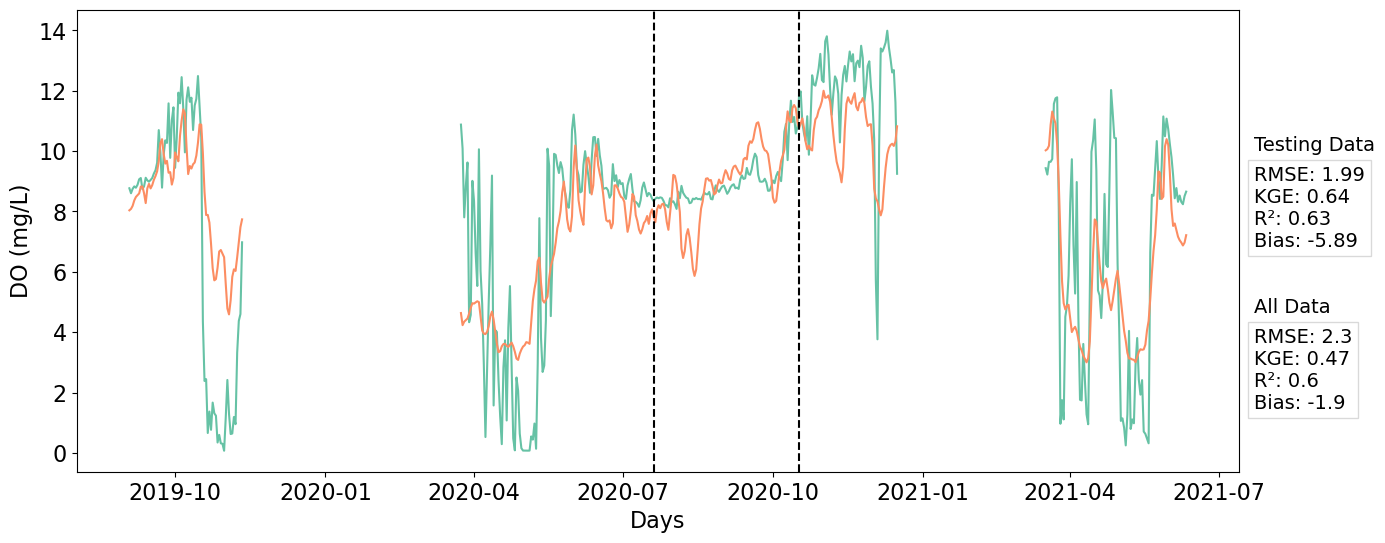

In [25]:
from src.utils import postprocessing as post

OC2_FT_metrics = post.plot_result_sites(y_OC2, OC2_preds, OC2_start, OC2_end, scaler_y, "OC2", FT=True, train=True)
LF1_FT_metrics = post.plot_result_sites(y_LF1, LF1_preds, LF1_start, LF1_end, scaler_y, "LF1", FT=True, train=True)
LF2_FT_metrics = post.plot_result_sites(y_LF2, LF2_preds, LF2_start, LF2_end, scaler_y, "LF2", FT=True, train=True)
OC4_FT_metrics = post.plot_result_sites(y_OC4, OC4_preds, OC4_start, OC4_end, scaler_y, "OC4", FT=True, train=True)
LF3_FT_metrics = post.plot_result_sites(y_LF3, LF3_preds, LF3_start, LF3_end, scaler_y, "LF3", FT=True, train=True)
OC1_FT_metrics = post.plot_result_sites(y_OC1, OC1_preds, OC1_start, OC1_end, scaler_y, "OC1", FT=True, train=True)
OC3_FT_metrics = post.plot_result_sites(y_OC3, OC3_preds, OC3_start, OC3_end, scaler_y, "OC3", FT=True, train=True)

In [26]:
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train_FP.columns)
model_FT_FRZ_RD = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False, freeze_recurrent=True)

# model_FT_FRZ_RD.load_weights(MODEL_DIR + '/River_LSTM.weights.h5')
model_FT_FRZ_RD.load_weights(MODEL_DIR + '/TL_FRZ_R_LSTM.weights.h5')

lstm_2
LSTM Layer
kernel
recurrent_kernel
bias
dropout_2
dense_2


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 8)              │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417 (5.54 KB)

 Trainable params: 1,120 (4.38 KB)

 Non-trainable params: 297 (1.16 KB)

/home/ghmyers/miniconda3/envs/TF_GPU/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
# model_name_FRZ_RD = "TL_FRZ_RD_LSTM_v4_oldFeatures"
# keras.utils.set_random_seed(seed)
# earlyStopping_FT = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=lr_schedule_patience, min_lr=0.0000001, verbose=1)
# checkpoint_callback_FT = tf.keras.callbacks.ModelCheckpoint(filepath=PROJECT_DIR + f'/models/{model_name_FRZ_RD}.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

# callbacks_FT_FRZ = [earlyStopping_FT, lr_scheduler, checkpoint_callback_FT]
# history_FT_FRZ = model_FT_FRZ_RD.fit(train_gen_FP, steps_per_epoch=steps_per_epoch_FP, batch_size=batch_size, 
#                     epochs=n_epochs, verbose=1, validation_data=test_gen_FP, 
#                     validation_steps=val_steps_FP, callbacks=callbacks_FT_FRZ)

# logger.info(f'Model ({model_name_FRZ_RD}) parameters:')
# logger.info(f'Seed: {seed}')
# logger.info(f'Activation: {activation_dense}')
# logger.info(f'Split Percentage: {split_pct}')
# logger.info(f'Hidden LSTM layers: {hidden_layers}')
# logger.info(f'Hidden units: {hidden_units}')
# logger.info(f'Window length: {window_length}')
# logger.info(f'Batch size: {batch_size}')
# logger.info(f'Learning rate: {learning_rate}')
# logger.info(f'Dropout: {dropout}')
# logger.info(f'Epochs: {n_epochs}')
# logger.info(f'Stop patience: {stop_patience}')
# logger.info(f"Learning rate scheduler patience: {lr_schedule_patience}")
# logger.info("Custom loss function: None")
# logger.info(f"Model loss: {history_FT_FRZ.history['loss']}")
# logger.info(f"Validation loss: {history_FT_FRZ.history['val_loss']}")

In [28]:
# plt.figure(figsize=(6,4), dpi=300)
# plt.plot(history_FT_FRZ.history['loss'])
# plt.plot(history_FT_FRZ.history['val_loss'])
# plt.title('TL-FRZ-RD-LSTM Model Loss')
# plt.ylabel('Loss (MSE)')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.tight_layout()
# plt.savefig(FIGURE_DIR + '/TL_LSTM_FRZ_RD_v4_loss.png', dpi=300)
# plt.show()

In [29]:
OC2_preds_FRZ_RD = model_FT_FRZ_RD.predict(X_OC2, batch_size=batch_size)
LF1_preds_FRZ_RD = model_FT_FRZ_RD.predict(X_LF1, batch_size=batch_size)
LF2_preds_FRZ_RD = model_FT_FRZ_RD.predict(X_LF2, batch_size=batch_size)
OC4_preds_FRZ_RD = model_FT_FRZ_RD.predict(X_OC4, batch_size=batch_size)
LF3_preds_FRZ_RD = model_FT_FRZ_RD.predict(X_LF3, batch_size=batch_size)
OC1_preds_FRZ_RD = model_FT_FRZ_RD.predict(X_OC1, batch_size=batch_size)
OC3_preds_FRZ_RD = model_FT_FRZ_RD.predict(X_OC3, batch_size=batch_size)

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


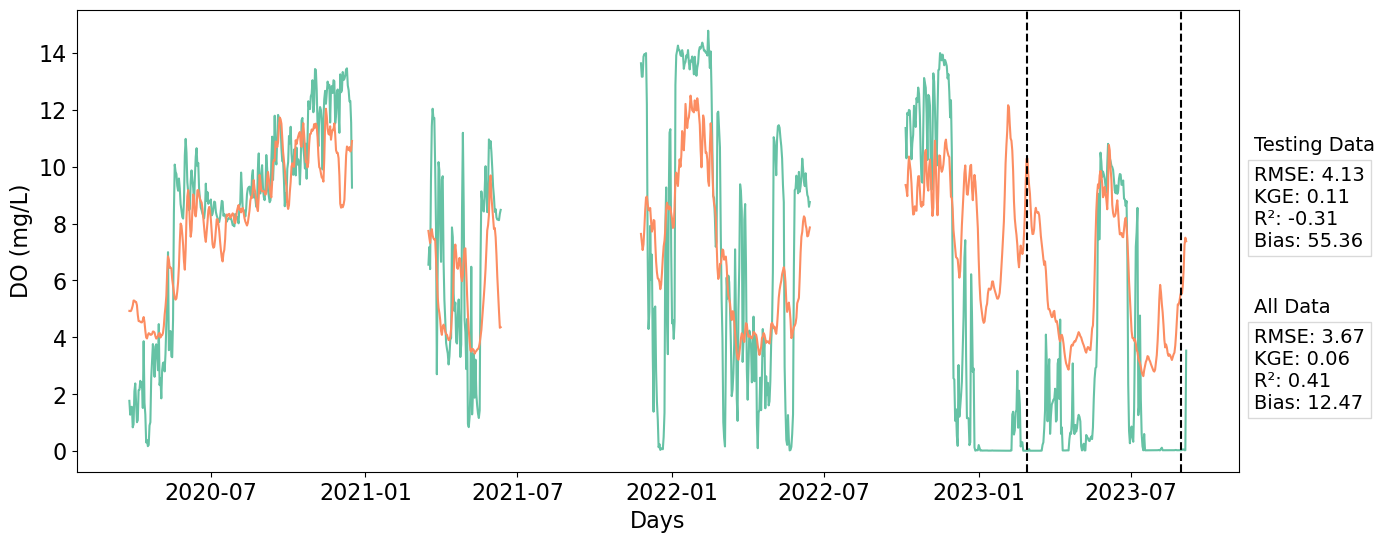

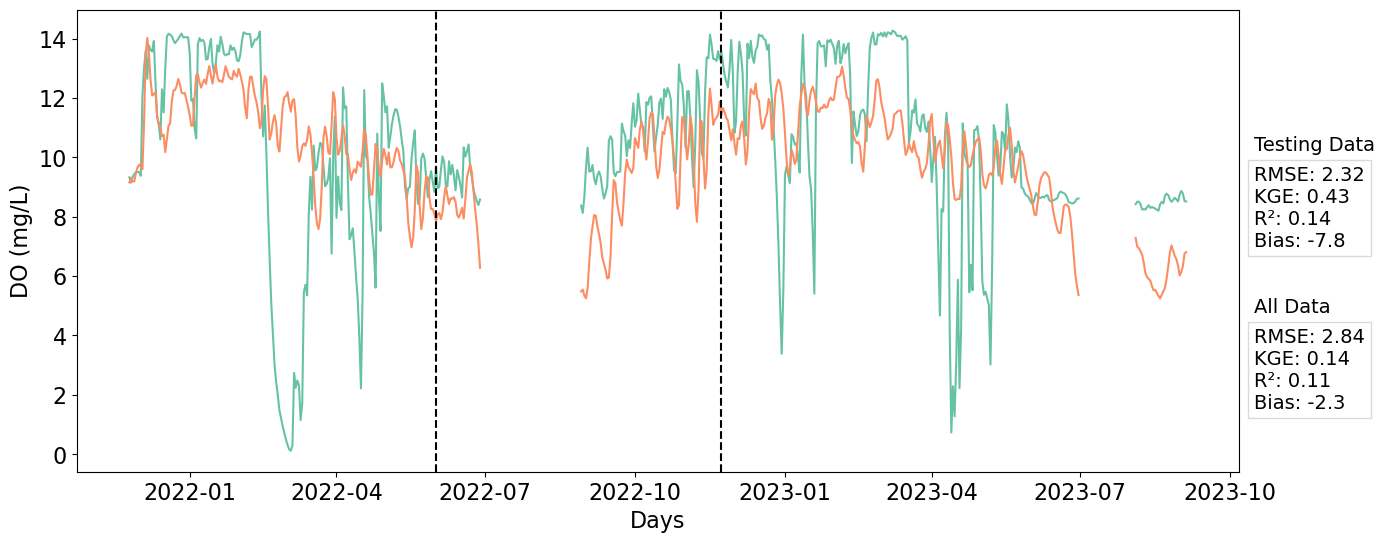

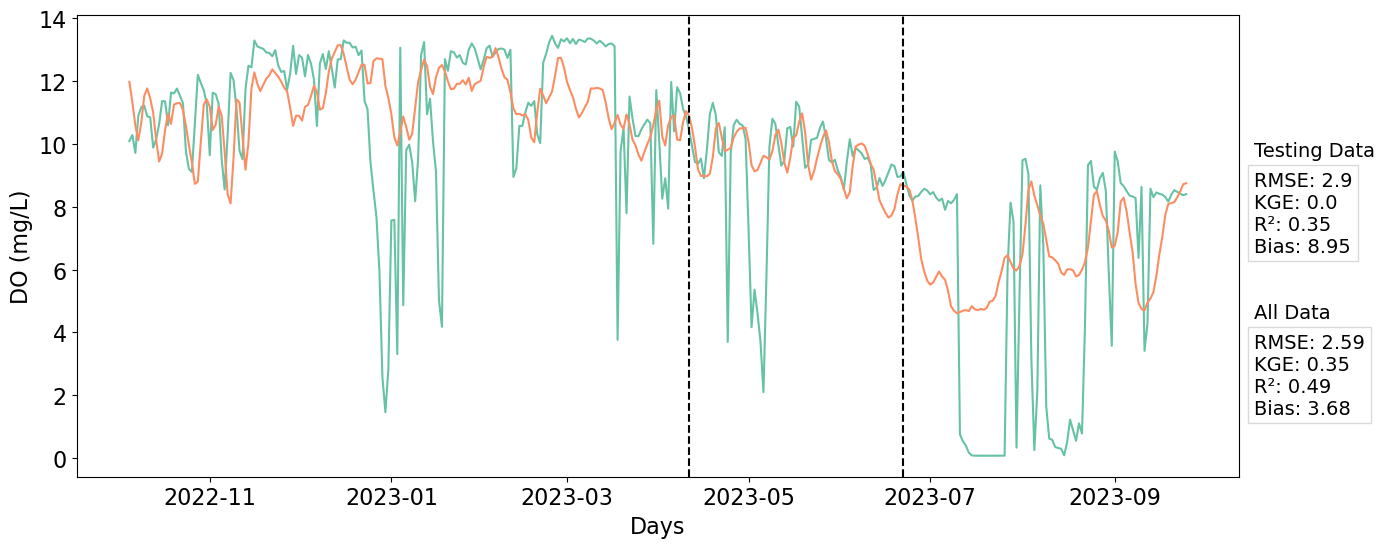

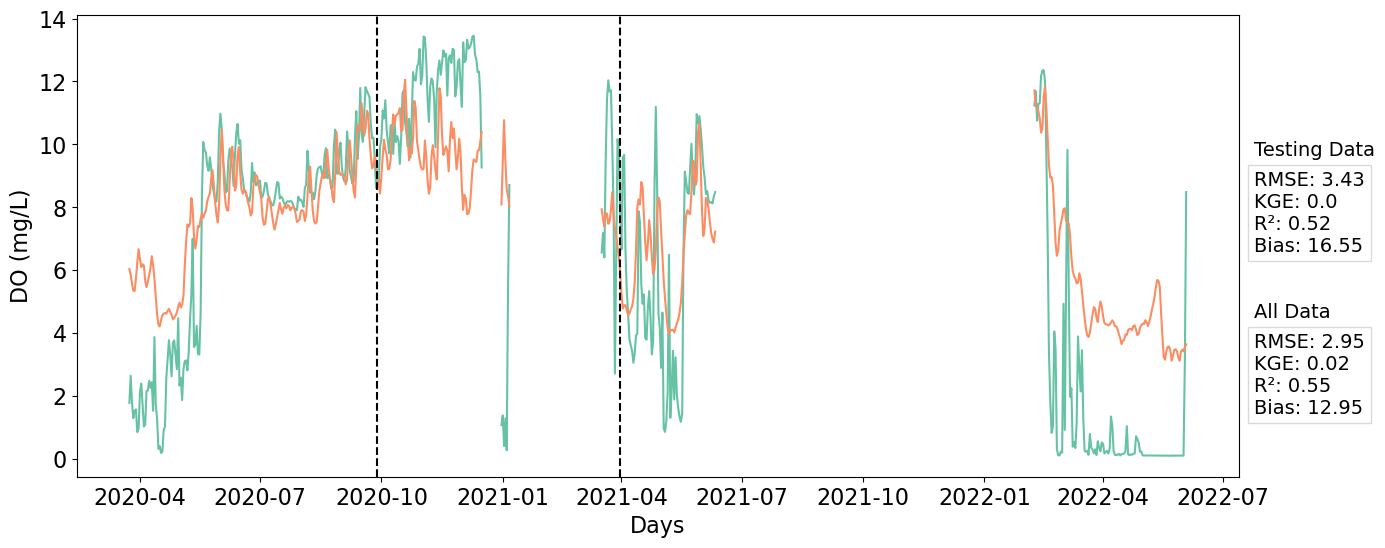

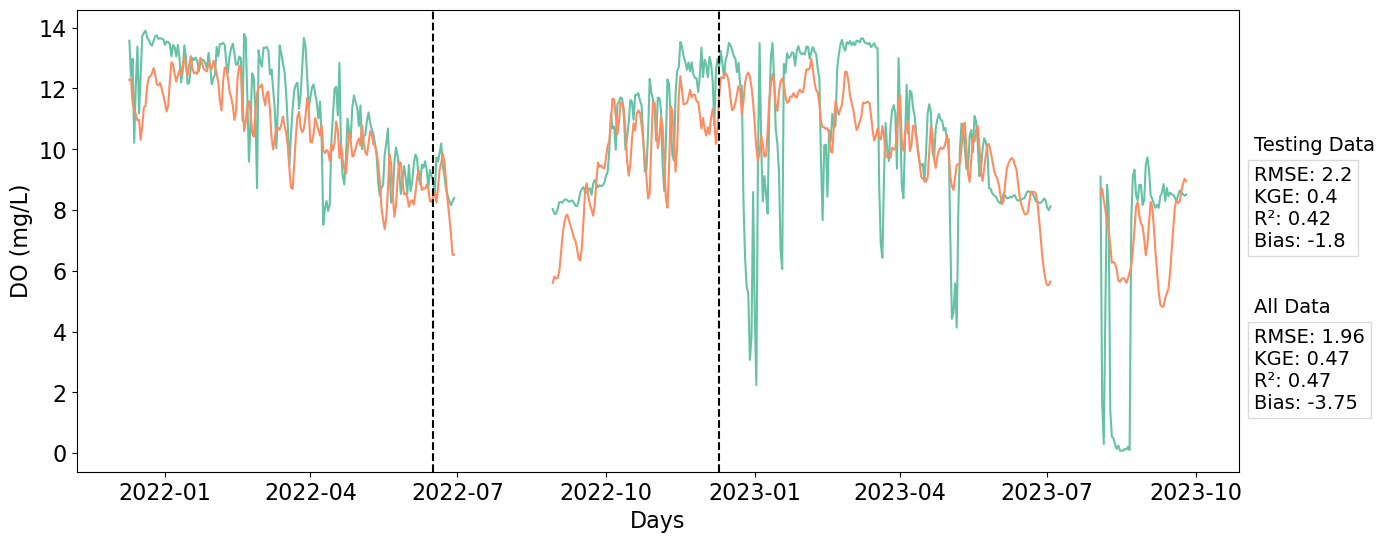

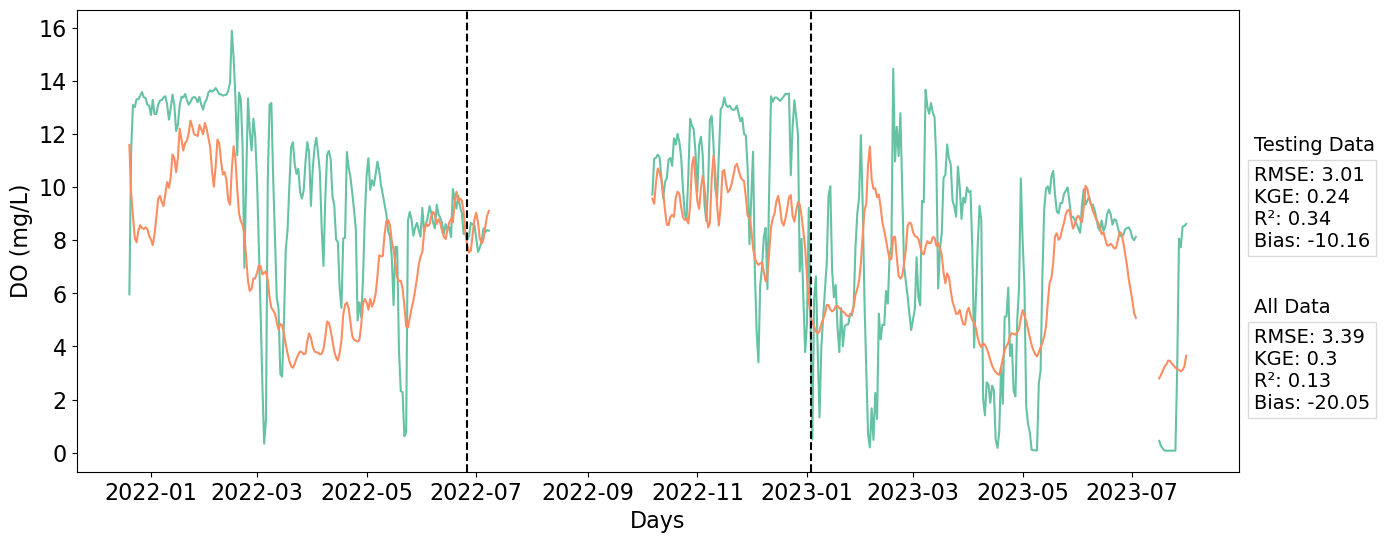

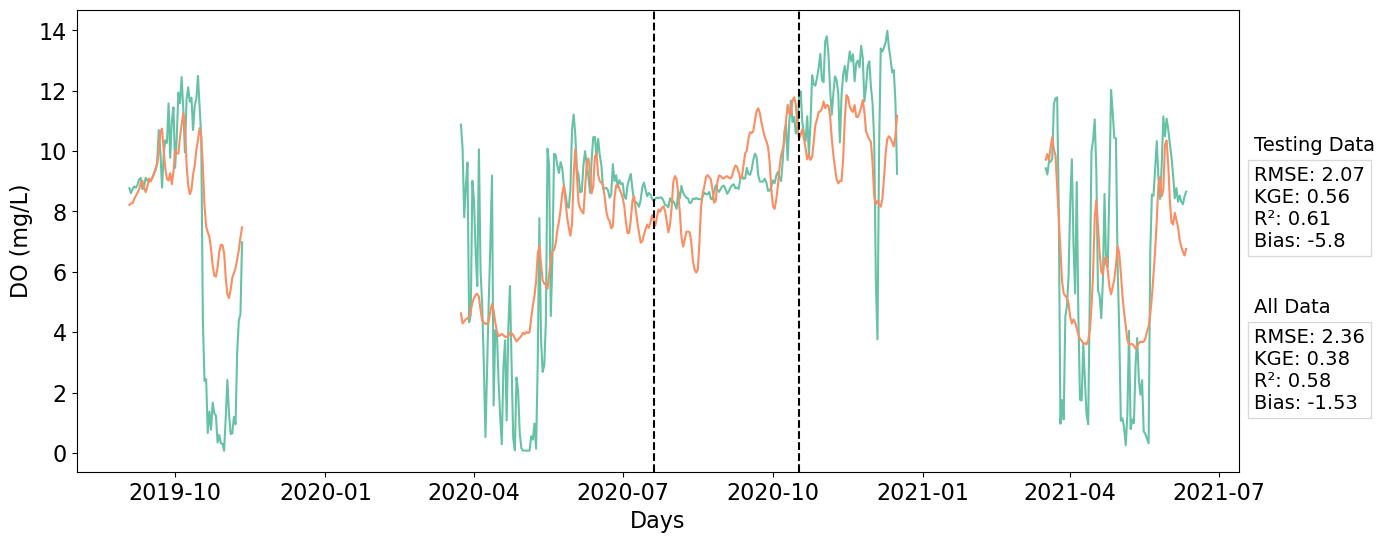

In [30]:
OC2_FT_FRZ_RD_metrics = post.plot_result_sites(y_OC2, OC2_preds_FRZ_RD, OC2_start, OC2_end, scaler_y, "OC2", FT=True, train=True)
LF1_FT_FRZ_RD_metrics = post.plot_result_sites(y_LF1, LF1_preds_FRZ_RD, LF1_start, LF1_end, scaler_y, "LF1", FT=True, train=True)
LF2_FT_FRZ_RD_metrics = post.plot_result_sites(y_LF2, LF2_preds_FRZ_RD, LF2_start, LF2_end, scaler_y, "LF2", FT=True, train=True)
OC4_FT_FRZ_RD_metrics = post.plot_result_sites(y_OC4, OC4_preds_FRZ_RD, OC4_start, OC4_end, scaler_y, "OC4", FT=True, train=True)
LF3_FT_FRZ_RD_metrics = post.plot_result_sites(y_LF3, LF3_preds_FRZ_RD, LF3_start, LF3_end, scaler_y, "LF3", FT=True, train=True)
OC1_FT_FRZ_RD_metrics = post.plot_result_sites(y_OC1, OC1_preds_FRZ_RD, OC1_start, OC1_end, scaler_y, "OC1", FT=True, train=True)
OC3_FT_FRZ_RD_metrics = post.plot_result_sites(y_OC3, OC3_preds_FRZ_RD, OC3_start, OC3_end, scaler_y, "OC3", FT=True, train=True)

In [31]:
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train_FP.columns)
model_FT_FRZ_KD = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False, freeze_kernel=True)

# model_FT_FRZ_KD.load_weights(PROJECT_DIR + '/models/old/River_LSTM.weights.h5')
model_FT_FRZ_KD.load_weights(MODEL_DIR + '/TL_FRZ_K_LSTM.weights.h5')

lstm_3
LSTM Layer
kernel
recurrent_kernel
bias
dropout_3
dense_3


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 8)              │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417 (5.54 KB)

 Trainable params: 256 (1.00 KB)

 Non-trainable params: 1,161 (4.54 KB)

/home/ghmyers/miniconda3/envs/TF_GPU/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Train LSTM just on site data

In [32]:
# model_name_FRZ_KD = "TL_FRZ_K_LSTM_v4"
# keras.utils.set_random_seed(seed)
# earlyStopping_FT = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=lr_schedule_patience, min_lr=0.0000001, verbose=1)
# checkpoint_callback_FT = tf.keras.callbacks.ModelCheckpoint(filepath=PROJECT_DIR + f'/models/{model_name_FRZ_KD}.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

# callbacks_FT_FRZ_KD = [earlyStopping_FT, lr_scheduler, checkpoint_callback_FT]
# history_FT_FRZ_KD = model_FT_FRZ_KD.fit(train_gen_FP, steps_per_epoch=steps_per_epoch_FP, batch_size=batch_size, 
#                     epochs=n_epochs, verbose=1, validation_data=test_gen_FP, 
#                     validation_steps=val_steps_FP, callbacks=callbacks_FT_FRZ_KD)

# logger.info(f'Model ({model_name_FRZ_KD}) parameters:')
# logger.info(f'Seed: {seed}')
# logger.info(f'Activation: {activation_dense}')
# logger.info(f'Split Percentage: {split_pct}')
# logger.info(f'Hidden LSTM layers: {hidden_layers}')
# logger.info(f'Hidden units: {hidden_units}')
# logger.info(f'Window length: {window_length}')
# logger.info(f'Batch size: {batch_size}')
# logger.info(f'Learning rate: {learning_rate}')
# logger.info(f'Dropout: {dropout}')
# logger.info(f'Epochs: {n_epochs}')
# logger.info(f'Stop patience: {stop_patience}')
# logger.info(f"Learning rate scheduler patience: {lr_schedule_patience}")
# logger.info("Custom loss function: None")
# logger.info(f"Model loss: {history_FT_FRZ.history['loss']}")
# logger.info(f"Validation loss: {history_FT_FRZ.history['val_loss']}")

In [33]:
# plt.figure(figsize=(6,4), dpi=300)
# plt.plot(history_FT_FRZ_KD.history['loss'])
# plt.plot(history_FT_FRZ_KD.history['val_loss'])
# plt.title('TL-FRZ-KD-LSTM Model Loss')
# plt.ylabel('Loss (MSE)')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.savefig(FIGURE_DIR + '/TL_LSTM_FRZ_K_v4.png', dpi=300)
# plt.show()

In [34]:
OC2_preds_FRZ_KD = model_FT_FRZ_KD.predict(X_OC2, batch_size=batch_size)
LF1_preds_FRZ_KD = model_FT_FRZ_KD.predict(X_LF1, batch_size=batch_size)
LF2_preds_FRZ_KD = model_FT_FRZ_KD.predict(X_LF2, batch_size=batch_size)
OC4_preds_FRZ_KD = model_FT_FRZ_KD.predict(X_OC4, batch_size=batch_size)
LF3_preds_FRZ_KD = model_FT_FRZ_KD.predict(X_LF3, batch_size=batch_size)
OC1_preds_FRZ_KD = model_FT_FRZ_KD.predict(X_OC1, batch_size=batch_size)
OC3_preds_FRZ_KD = model_FT_FRZ_KD.predict(X_OC3, batch_size=batch_size)

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Fine-tune only the dense output layer

In [35]:
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train_FP.columns)
model_FT_FRZ = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False, freeze_all=True)

# model_FT_FRZ.load_weights(PROJECT_DIR + '/models/old/River_LSTM.weights.h5')
model_FT_FRZ.load_weights(MODEL_DIR + '/TL_FRZ_LSTM.weights.h5')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8)              │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417 (5.54 KB)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 1,408 (5.50 KB)

/home/ghmyers/miniconda3/envs/TF_GPU/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
# model_name_FRZ = "TL_FRZ_LSTM_v4_oldFeatures"
# keras.utils.set_random_seed(seed)
# earlyStopping_FT = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=lr_schedule_patience, min_lr=0.0000001, verbose=1)
# checkpoint_callback_FT = tf.keras.callbacks.ModelCheckpoint(filepath=PROJECT_DIR + f'/models/{model_name_FRZ}.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

# callbacks_FT_FRZ = [earlyStopping_FT, lr_scheduler, checkpoint_callback_FT]
# history_FT_FRZ = model_FT_FRZ.fit(train_gen_FP, steps_per_epoch=steps_per_epoch_FP, batch_size=batch_size, 
#                     epochs=n_epochs, verbose=1, validation_data=test_gen_FP, 
#                     validation_steps=val_steps_FP, callbacks=callbacks_FT_FRZ)

# logger.info(f'Model ({model_name_FRZ}) parameters:')
# logger.info(f'Seed: {seed}')
# logger.info(f'Activation: {activation_dense}')
# logger.info(f'Split Percentage: {split_pct}')
# logger.info(f'Hidden LSTM layers: {hidden_layers}')
# logger.info(f'Hidden units: {hidden_units}')
# logger.info(f'Window length: {window_length}')
# logger.info(f'Batch size: {batch_size}')
# logger.info(f'Learning rate: {learning_rate}')
# logger.info(f'Dropout: {dropout}')
# logger.info(f'Epochs: {n_epochs}')
# logger.info(f'Stop patience: {stop_patience}')
# logger.info(f"Learning rate scheduler patience: {lr_schedule_patience}")
# logger.info("Custom loss function: None")
# logger.info(f"Model loss: {history_FT_FRZ.history['loss']}")
# logger.info(f"Validation loss: {history_FT_FRZ.history['val_loss']}")

In [37]:
# plt.figure(figsize=(6,4), dpi=300)
# plt.plot(history_FT_FRZ.history['loss'])
# plt.plot(history_FT_FRZ.history['val_loss'])
# plt.title('TL-FRZ-LSTM Model Loss')
# plt.ylabel('Loss (MSE)')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.savefig(FIGURE_DIR + '/TL_LSTM_FRZ_v4_loss.png', dpi=300)
# plt.show()

In [38]:
OC2_preds_FRZ = model_FT_FRZ.predict(X_OC2, batch_size=batch_size)
LF1_preds_FRZ = model_FT_FRZ.predict(X_LF1, batch_size=batch_size)
LF2_preds_FRZ = model_FT_FRZ.predict(X_LF2, batch_size=batch_size)
OC4_preds_FRZ = model_FT_FRZ.predict(X_OC4, batch_size=batch_size)
LF3_preds_FRZ = model_FT_FRZ.predict(X_LF3, batch_size=batch_size)
OC1_preds_FRZ = model_FT_FRZ.predict(X_OC1, batch_size=batch_size)
OC3_preds_FRZ = model_FT_FRZ.predict(X_OC3, batch_size=batch_size)

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [39]:
with open(os.path.join(CONFIG_DIR, "FP_lstm4_config.yaml"), "r") as f:
    config = yaml.safe_load(f)

# Set hyperparameters from config file
seed = config['seed']
split_pct = config['split_pct']
window_length = config['window_length']
hidden_layers = config['hidden_layers']
hidden_units = config['hidden_units']
batch_size = config['batch_size']
n_epochs = config['n_epochs']
activation_dense = config['activation_dense']
# learning_rate = config['learning_rate']
learning_rate = 8e-5
dropout = config['dropout']
stop_patience = config['stop_patience']
lr_schedule_patience = config['lr_schedule_patience']

In [40]:
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train_FP.columns)
model_FP = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)

model_FP.load_weights(MODEL_DIR + '/FP_LSTM.weights.h5')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 8)              │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417 (5.54 KB)

 Trainable params: 1,417 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

/home/ghmyers/miniconda3/envs/TF_GPU/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
# model_name = "FP_LSTM_v4_oldFeatures"
# keras.utils.set_random_seed(seed)
# earlyStopping_FP = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=lr_schedule_patience, min_lr=0.0000001, verbose=1)
# checkpoint_callback_FP = tf.keras.callbacks.ModelCheckpoint(filepath=PROJECT_DIR + f'/models/{model_name}.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

# callbacks_FP = [earlyStopping_FP, lr_scheduler, checkpoint_callback_FP]
# history_FP = model_FP.fit(train_gen_FP, steps_per_epoch=steps_per_epoch_FP, batch_size=batch_size, 
#                     epochs=n_epochs, verbose=1, validation_data=test_gen_FP, 
#                     validation_steps=val_steps_FP, callbacks=callbacks_FP)

# logger.info(f'Model ({model_name}) parameters:')
# logger.info(f'Seed: {seed}')
# logger.info(f'Activation: {activation_dense}')
# logger.info(f'Split Percentage: {split_pct}')
# logger.info(f'Hidden LSTM layers: {hidden_layers}')
# logger.info(f'Hidden units: {hidden_units}')
# logger.info(f'Window length: {window_length}')
# logger.info(f'Batch size: {batch_size}')
# logger.info(f'Learning rate: {learning_rate}')
# logger.info(f'Dropout: {dropout}')
# logger.info(f'Epochs: {n_epochs}')
# logger.info(f'Stop patience: {stop_patience}')
# logger.info(f"Learning rate scheduler patience: {lr_schedule_patience}")
# logger.info("Custom loss function: None")
# logger.info(f"Model loss: {history_FP.history['loss']}")
# logger.info(f"Validation loss: {history_FP.history['val_loss']}")

In [42]:
# plt.figure(figsize=(6,4), dpi=300)
# plt.plot(history_FP.history['loss'])
# plt.plot(history_FP.history['val_loss'])
# plt.title('FP-LSTM Model Loss')
# plt.ylabel('Loss (MSE)')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.tight_layout()
# # plt.savefig(FIGURE_DIR + '/FP_LSTM_v4_loss.png', dpi=300)
# plt.show()

In [43]:
OC2_preds_FP = model_FP.predict(X_OC2, batch_size=batch_size)
LF1_preds_FP = model_FP.predict(X_LF1, batch_size=batch_size)
LF2_preds_FP = model_FP.predict(X_LF2, batch_size=batch_size)
OC4_preds_FP = model_FP.predict(X_OC4, batch_size=batch_size)
LF3_preds_FP = model_FP.predict(X_LF3, batch_size=batch_size)
OC1_preds_FP = model_FP.predict(X_OC1, batch_size=batch_size)
OC3_preds_FP = model_FP.predict(X_OC3, batch_size=batch_size)

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


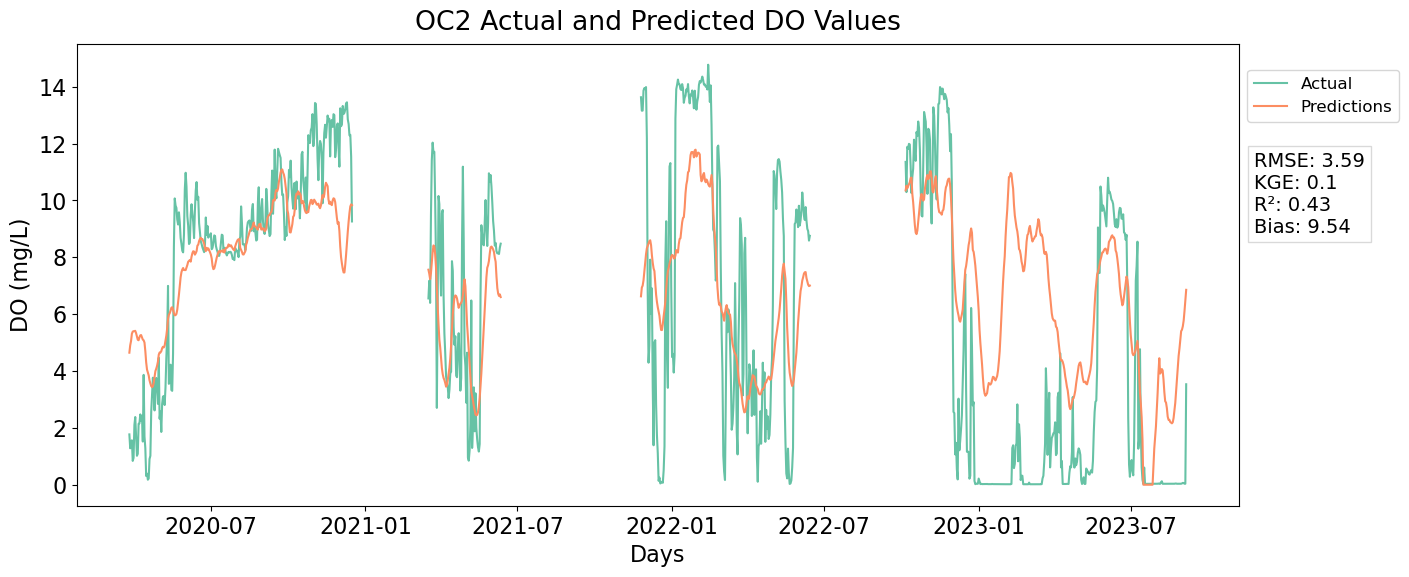

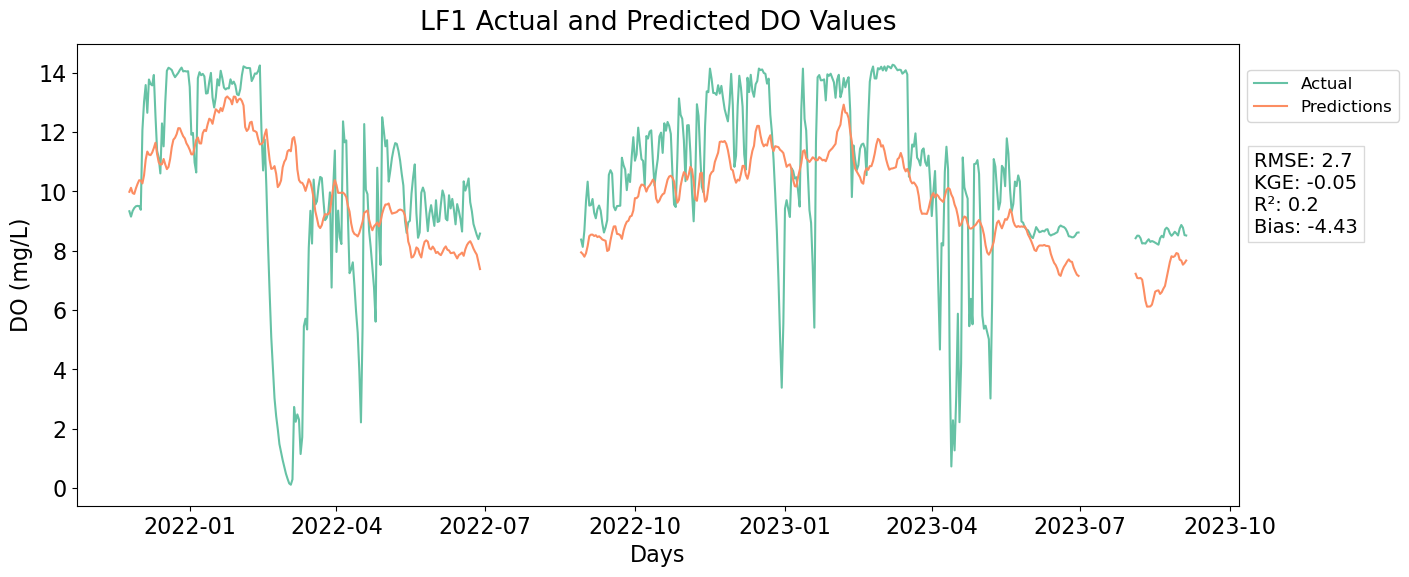

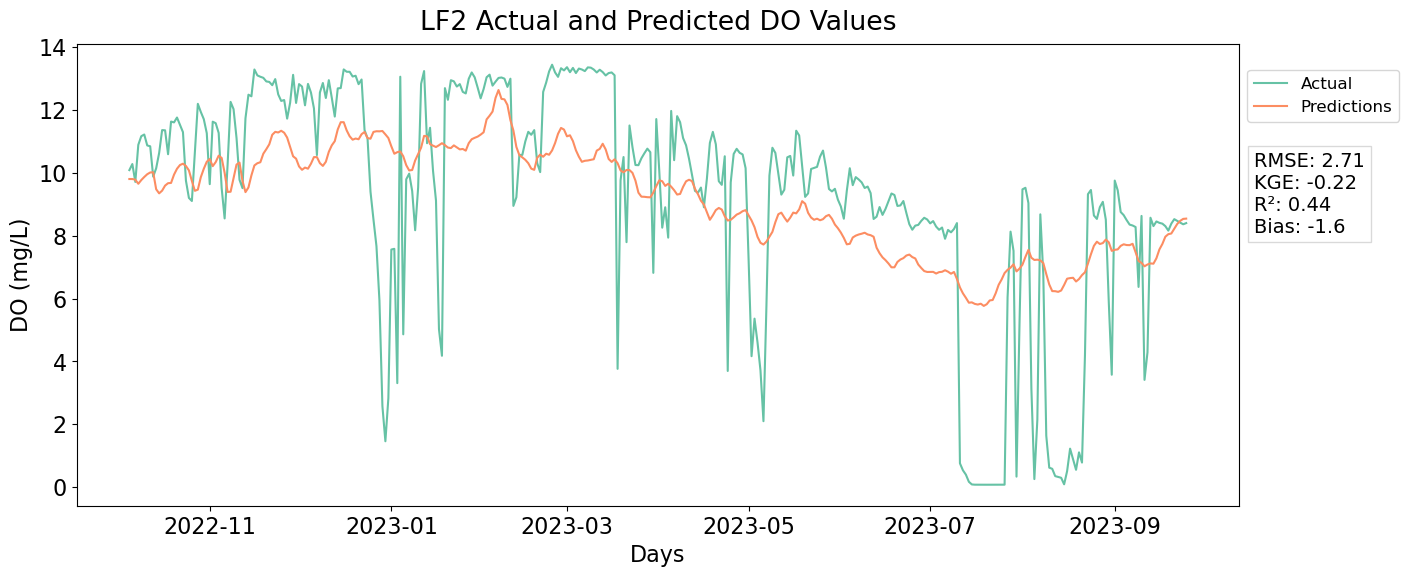

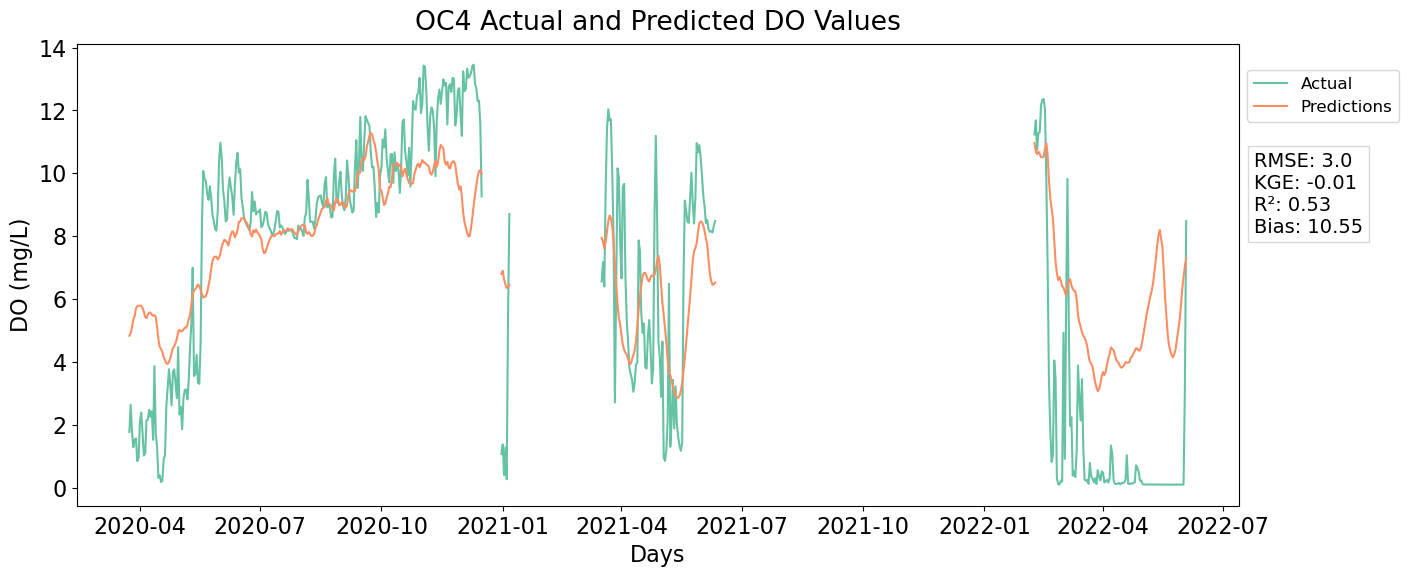

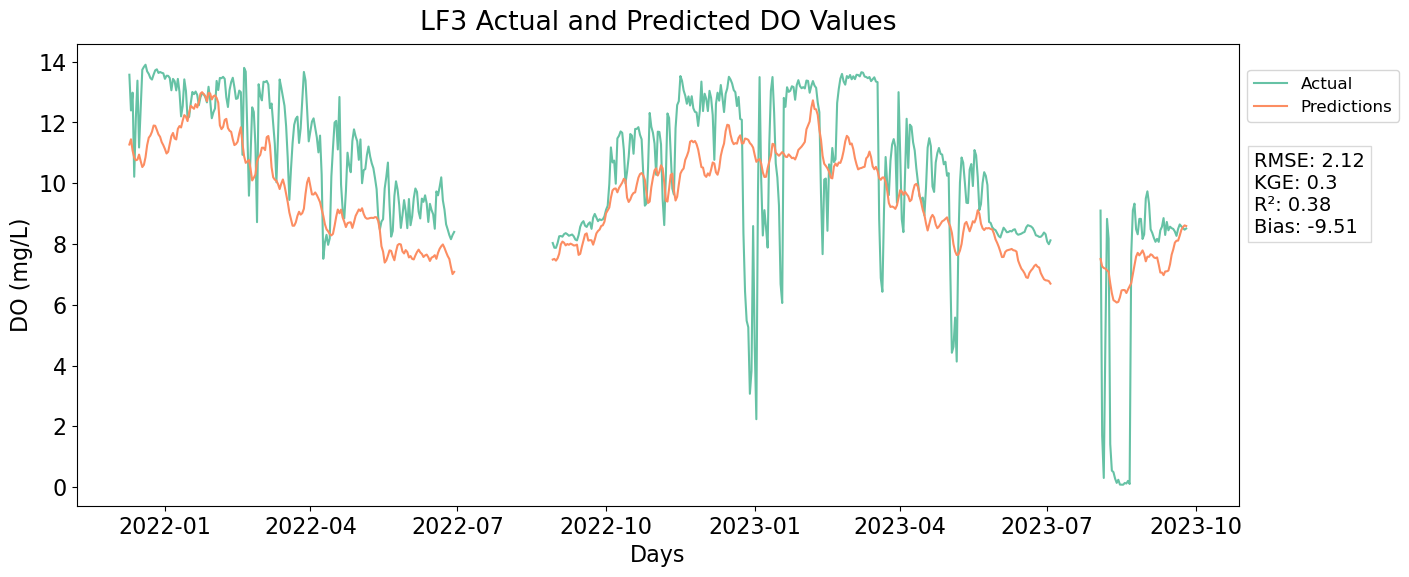

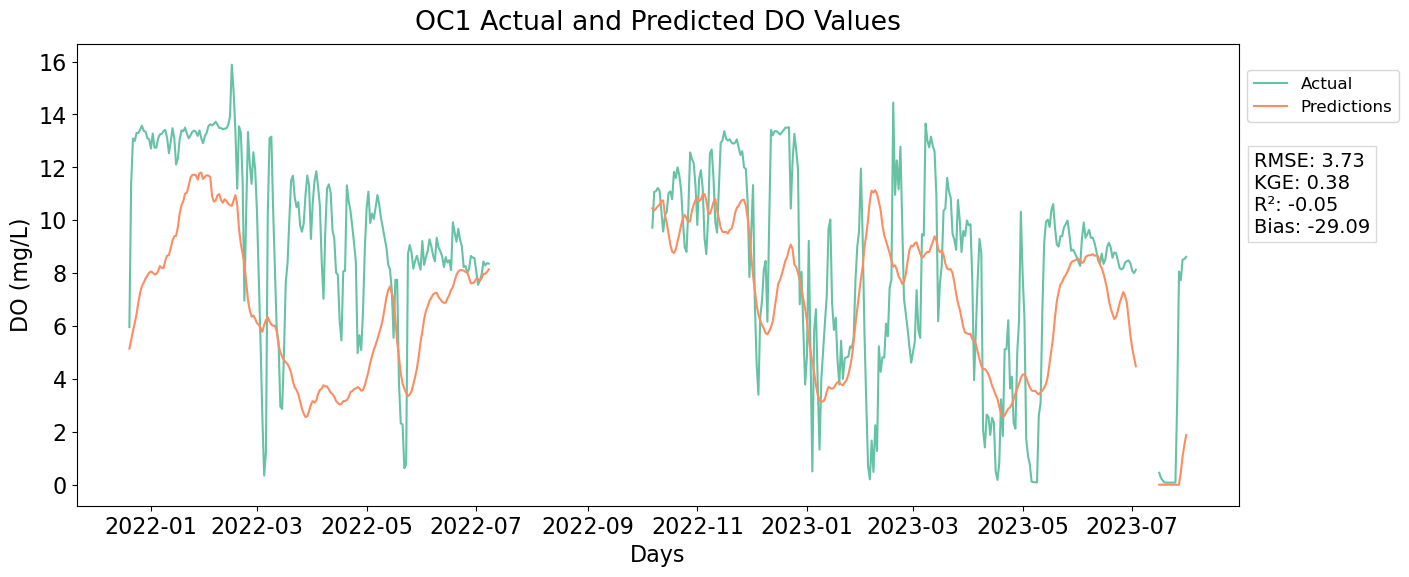

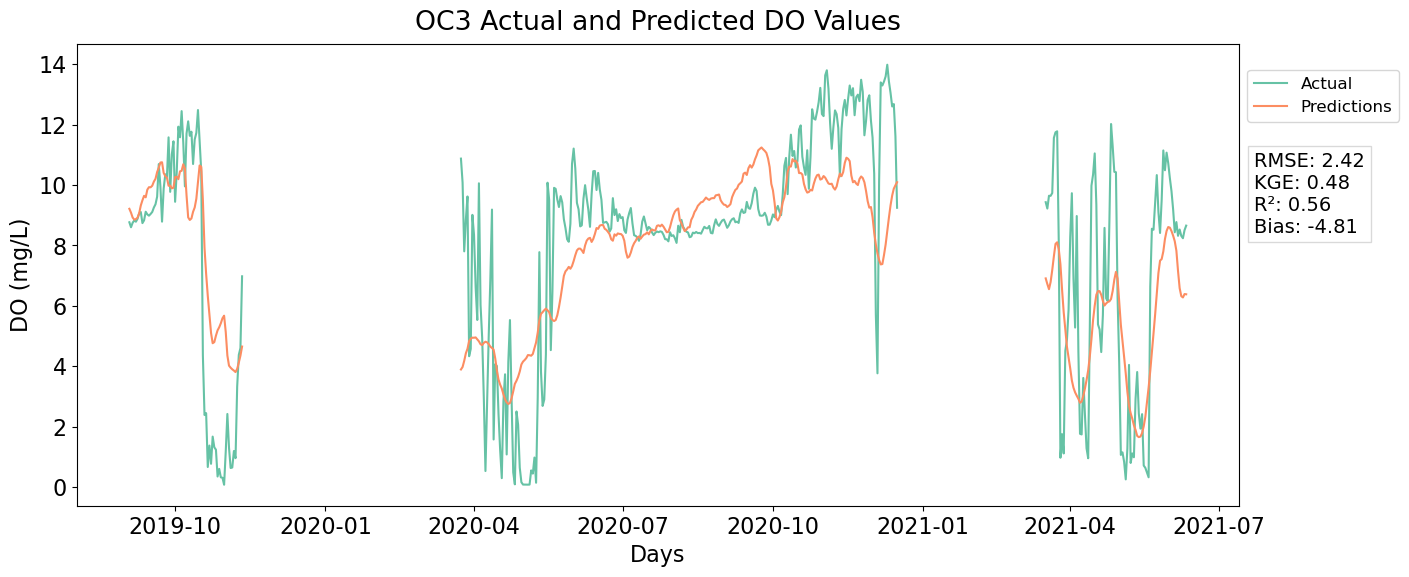

In [44]:
OC2_FP_metrics = post.plot_result_sites(y_OC2, OC2_preds_FP, OC2_start, OC2_end, scaler_y, "OC2", FT=False, train=False)
LF3_FP_metrics = post.plot_result_sites(y_LF1, LF1_preds_FP, LF1_start, LF1_end, scaler_y, "LF1", FT=False, train=False)
LF2_FP_metrics = post.plot_result_sites(y_LF2, LF2_preds_FP, LF2_start, LF2_end, scaler_y, "LF2", FT=False, train=False)
OC4_FP_metrics = post.plot_result_sites(y_OC4, OC4_preds_FP, OC4_start, OC4_end, scaler_y, "OC4", FT=False, train=False)
LF3_FP_metrics = post.plot_result_sites(y_LF3, LF3_preds_FP, LF3_start, LF3_end, scaler_y, "LF3", FT=False, train=False)
OC1_FP_metrics = post.plot_result_sites(y_OC1, OC1_preds_FP, OC1_start, OC1_end, scaler_y, "OC1", FT=False, train=False)
OC3_FP_metrics = post.plot_result_sites(y_OC3, OC3_preds_FP, OC3_start, OC3_end, scaler_y, "OC3", FT=False, train=False)

#### Pretrained model predictions

In [45]:
OC2_preds_PT = model.predict(X_OC2, batch_size=batch_size)
LF1_preds_PT = model.predict(X_LF1, batch_size=batch_size)
LF2_preds_PT = model.predict(X_LF2, batch_size=batch_size)
OC4_preds_PT = model.predict(X_OC4, batch_size=batch_size)
LF3_preds_PT = model.predict(X_LF3, batch_size=batch_size)
OC1_preds_PT = model.predict(X_OC1, batch_size=batch_size)
OC3_preds_PT = model.predict(X_OC3, batch_size=batch_size)

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Save predictions into CSVs for statistical analysis

In [46]:
# from utils import postprocessing as post
OC2_pred_df = post.get_prediction_dataframe(y_OC2, OC2_preds_PT, OC2_preds, OC2_preds_FRZ, OC2_preds_FRZ_KD, OC2_preds_FRZ_RD, OC2_preds_FP, scaler_y, "OC2")
OC2_pred_df.to_csv(PROJECT_DIR + f'/outputs/results/OC2_model_predictions.csv')
LF1_pred_df = post.get_prediction_dataframe(y_LF1, LF1_preds_PT, LF1_preds, LF1_preds_FRZ, LF1_preds_FRZ_KD, LF1_preds_FRZ_RD, LF1_preds_FP, scaler_y, "LF1")
LF1_pred_df.to_csv(PROJECT_DIR + f'/outputs/results/LF1_model_predictions.csv')
LF2_pred_df = post.get_prediction_dataframe(y_LF2, LF2_preds_PT, LF2_preds, LF2_preds_FRZ, LF2_preds_FRZ_KD, LF2_preds_FRZ_RD, LF2_preds_FP, scaler_y, "LF2")
LF2_pred_df.to_csv(PROJECT_DIR + f'/outputs/results/LF2_model_predictions.csv')
OC4_pred_df = post.get_prediction_dataframe(y_OC4, OC4_preds_PT, OC4_preds, OC4_preds_FRZ, OC4_preds_FRZ_KD, OC4_preds_FRZ_RD, OC4_preds_FP, scaler_y, 'OC4')
OC4_pred_df.to_csv(PROJECT_DIR + f'/outputs/results/OC4_model_predictions.csv')
LF3_pred_df = post.get_prediction_dataframe(y_LF3, LF3_preds_PT, LF3_preds, LF3_preds_FRZ, LF3_preds_FRZ_KD, LF3_preds_FRZ_RD, LF3_preds_FP, scaler_y, 'LF3')
LF3_pred_df.to_csv(PROJECT_DIR + f'/outputs/results/LF3_model_predictions.csv')
OC1_pred_df = post.get_prediction_dataframe(y_OC1, OC1_preds_PT, OC1_preds, OC1_preds_FRZ, OC1_preds_FRZ_KD, OC1_preds_FRZ_RD, OC1_preds_FP, scaler_y, 'OC1')
OC1_pred_df.to_csv(PROJECT_DIR + f'/outputs/results/OC1_model_predictions.csv')
OC3_pred_df = post.get_prediction_dataframe(y_OC3, OC3_preds_PT, OC3_preds, OC3_preds_FRZ, OC3_preds_FRZ_KD, OC3_preds_FRZ_RD, OC3_preds_FP, scaler_y, 'OC3')
OC3_pred_df.to_csv(PROJECT_DIR + f'/outputs/results/OC3_model_predictions.csv')

In [47]:
pred_df_dict = {'OC2': OC2_pred_df, 'LF1': LF1_pred_df, 'LF2': LF2_pred_df, 'OC4': OC4_pred_df, 'LF3': LF3_pred_df, 'OC1': OC1_pred_df, 'OC3': OC3_pred_df}
results_df, results_df_low = post.analyze_model_results(pred_df_dict)
results_df.to_csv(os.path.join(OUTPUT_DIR, 'results', 'model_metrics.csv'))
results_df_low.to_csv(os.path.join(OUTPUT_DIR, 'results', 'model_metrics_low.csv'))

OC2
LF1
LF2
OC4
LF3
OC1
OC3


In [48]:
results_df_noKDFRZ = post.analyze_model_results_noKDFRZ(pred_df_dict)
results_df_noKDFRZ.to_csv(os.path.join(OUTPUT_DIR, 'results', 'model_metrics_noFRZK_noFRZ.csv'))

In [49]:
import scipy.stats as stats
import scikit_posthocs as sp
import itertools

stats_df = post.run_posthoc_tests(results_df)
stats_df.to_csv(os.path.join(OUTPUT_DIR, 'results', 'posthoc_stats.csv'), index=False)

In [ ]:
stats_df_noKDFRZ = post.run_posthoc_tests_noKDFRZ(results_df_noKDFRZ)
stats_df_noKDFRZ.to_csv(os.path.join(OUTPUT_DIR, 'results', 'posthoc_stats_noKD_noFRZ.csv'), index=False)

In [88]:
import seaborn as sns
def add_significance_brackets(ax, pairs,
                              y_offset_frac=0.1,      # vertical gap between rows of brackets
                              bracket_height_frac=0.015, # height of each bracket
                              text_pad_frac=0.0001,       # extra pad for asterisks
                              fontsize=10):
    """
    Draw significance brackets whose spacing is a *fraction* of the axis height,
    so appearance is consistent regardless of data scale.
    """
    ylim_orig = ax.get_ylim()
    y_range   = ylim_orig[1] - ylim_orig[0]

    for i, (idx1, idx2, label) in enumerate(pairs):
        # Convert box index (0‑based) ➜ x‑position (1‑based as mpl draws them)
        x1, x2 = idx1 + 1, idx2 + 1

        # Vertical position of this row’s bracket (in data coords)
        y_base = ylim_orig[1] + (i + 1) * y_offset_frac * y_range
        h      = bracket_height_frac * y_range

        # Bracket
        ax.plot([x1, x1, x2, x2],
                [y_base, y_base + h, y_base + h, y_base],
                lw=1.5, c='black', clip_on=False)

        # Text (asterisks / p‑value)
        ax.text((x1 + x2) * 0.5,
                y_base + h + text_pad_frac * y_range,
                label, ha='center', va='bottom',
                fontsize=fontsize, clip_on=False)

    # Expand the y‑axis so everything is visible
    extra_space = (len(pairs) + 2) * y_offset_frac * y_range
    ax.set_ylim(ylim_orig[0], ylim_orig[1] + extra_space)
# -----------------------------------------------------------------------------
def boxplot_model_performance_with_significance(summary_df, stats_df, figpath):
    metrics      = ['RMSE', 'KGE', 'R²', 'Bias']
    model_names  = ["River LSTM", "Floodplain LSTM", "TL LSTM"]
    panel_labels = ["a)", "b)", "c)", "d)"]

    # colors       = plt.cm.tab10(np.linspace(0, 1, 8))
    colors = sns.color_palette('icefire')
    color_list   = [colors[0], colors[1], colors[2]]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, (ax, metric) in enumerate(zip(axes, metrics)):
        # ---------- Box‑and‑whisker -------------------------------------------------
        data = [summary_df[f"{model} {metric}"].dropna()
                for model in model_names]

        bp = ax.boxplot(data, labels=model_names, patch_artist=True)

        # color & style
        for patch, color in zip(bp['boxes'], color_list):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
        for med in bp['medians']:
            med.set_color('black'); med.set_linewidth(2)

        ax.spines[['right', 'top']].set_visible(False)
        ax.grid(False)
        ax.set_title(f"{panel_labels[i]} {metric} Distribution Across Models", fontsize=14)
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=30, labelsize=12)

        # ----------- Median labels -------------------------------------------------
        y_range     = ax.get_ylim()[1] - ax.get_ylim()[0]
        text_offset = 0.01 * y_range                       # 1 % of axis height

        for i, d in enumerate(data):
            y_val = np.percentile(d, 100)
            med_val = np.mean(d)
            ax.text(i + 1,                               # x‑position (1‑based)
                    y_val + text_offset,               # just above median line
                    f"{med_val:.2f}",
                    ha='center', va='bottom',
                    fontsize=10, color='black')
        # ---------- Significance annotations ---------------------------------------
        dunn_results = (
            stats_df.loc[
                (stats_df['Metric'] == metric) &
                (stats_df['Test']   == 'Dunn-Bonferroni') &
                (stats_df['Significant'])
            ]
        )

        if not dunn_results.empty:
            pairs = []
            for _, row in dunn_results.iterrows():
                try:
                    idx1 = model_names.index(row['Group1'])
                    idx2 = model_names.index(row['Group2'])
                except ValueError:
                    continue 

                # Add p-valu * label
                p = row['p-value']
                label = "***" if p < 0.005 else "**" if p < 0.01 else "*" if p < 0.05 else ""
                pairs.append((min(idx1, idx2), max(idx1, idx2), label))

            if pairs:
                add_significance_brackets(ax, pairs)

    plt.tight_layout()
    plt.savefig(figpath, dpi=600)
    plt.show()
# -----------------------------------------------------------------------------
def boxplot_model_performance_with_significance_TL_models(summary_df, stats_df, figpath):
    metrics      = ['RMSE', 'KGE', 'R²', 'Bias']
    model_names  = ["River LSTM", "Floodplain LSTM", "TL LSTM", "TL-FRZ LSTM",
                    "TL-FRZ-K LSTM", "TL-FRZ-R LSTM"]
    panel_labels = ["a)", "b)", "c)", "d)"]

    # colors       = plt.cm.tab10(np.linspace(0, 1, 8))
    colors = sns.color_palette('icefire')
    color_list   = [colors[0], colors[1], colors[2],
                    colors[3], colors[4], colors[5]]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, (ax, metric) in enumerate(zip(axes, metrics)):
        # ---------- Box‑and‑whisker -------------------------------------------------
        data = [summary_df[f"{model} {metric}"].dropna()
                for model in model_names]

        bp = ax.boxplot(data, labels=model_names, patch_artist=True)

        # color & style
        for patch, color in zip(bp['boxes'], color_list):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
        for med in bp['medians']:
            med.set_color('black'); med.set_linewidth(2)

        ax.spines[['right', 'top']].set_visible(False)
        ax.grid(False)
        ax.set_title(f"{panel_labels[i]} {metric} Distribution Across Models", fontsize=14)
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=30, labelsize=12)

        # ----------- Median labels -------------------------------------------------
        y_range     = ax.get_ylim()[1] - ax.get_ylim()[0]
        text_offset = 0.01 * y_range                       # 1 % of axis height

        for i, d in enumerate(data):
            y_val = np.percentile(d, 100)
            med_val = np.mean(d)
            ax.text(i + 1,                               # x‑position (1‑based)
                    y_val + text_offset,               # just above median line
                    f"{med_val:.2f}",
                    ha='center', va='bottom',
                    fontsize=10, color='black')
        # ---------- Significance annotations ---------------------------------------
        dunn_results = (
            stats_df.loc[
                (stats_df['Metric'] == metric) &
                (stats_df['Test']   == 'Dunn-Bonferroni') &
                (stats_df['Significant'])
            ]
        )

        if not dunn_results.empty:
            pairs = []
            for _, row in dunn_results.iterrows():
                try:
                    idx1 = model_names.index(row['Group1'])
                    idx2 = model_names.index(row['Group2'])
                except ValueError:
                    continue 

                # Add p-valu * label
                p = row['p-value']
                label = "***" if p < 0.005 else "**" if p < 0.01 else "*" if p < 0.05 else ""
                pairs.append((min(idx1, idx2), max(idx1, idx2), label))

            if pairs:
                add_significance_brackets(ax, pairs)

    plt.tight_layout()
    plt.savefig(figpath, dpi=600)
    plt.show()

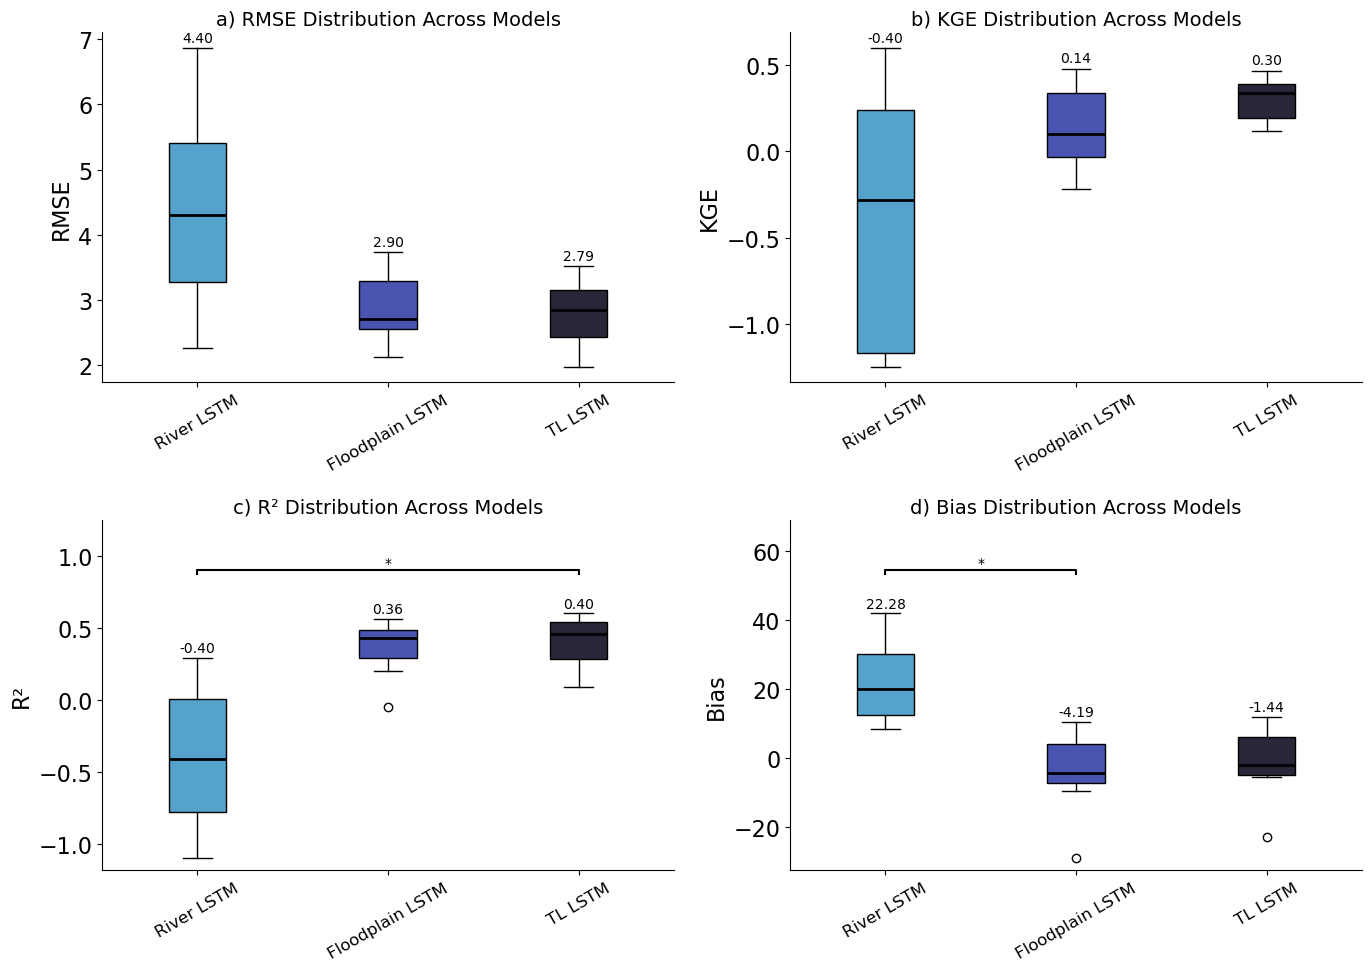

In [84]:
figpath = os.path.join(FIGURE_DIR, 'boxplots', 'model_performance_significance.png')
boxplot_model_performance_with_significance(results_df, stats_df, figpath)

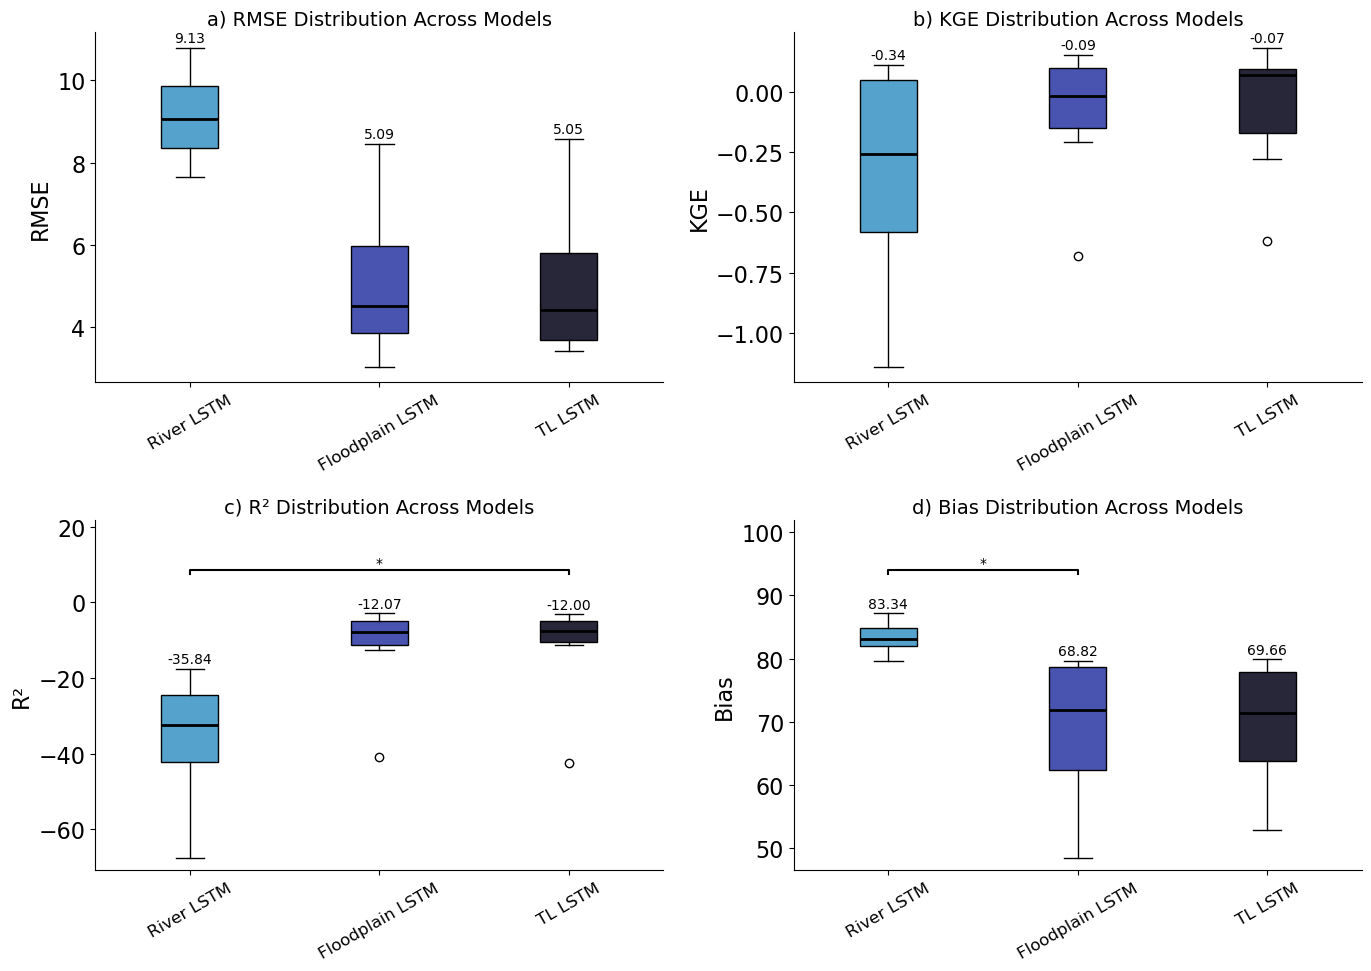

In [91]:
figpath = os.path.join(FIGURE_DIR, 'boxplots', 'model_performance_significance_low.png')
boxplot_model_performance_with_significance(results_df_low, stats_df, figpath)

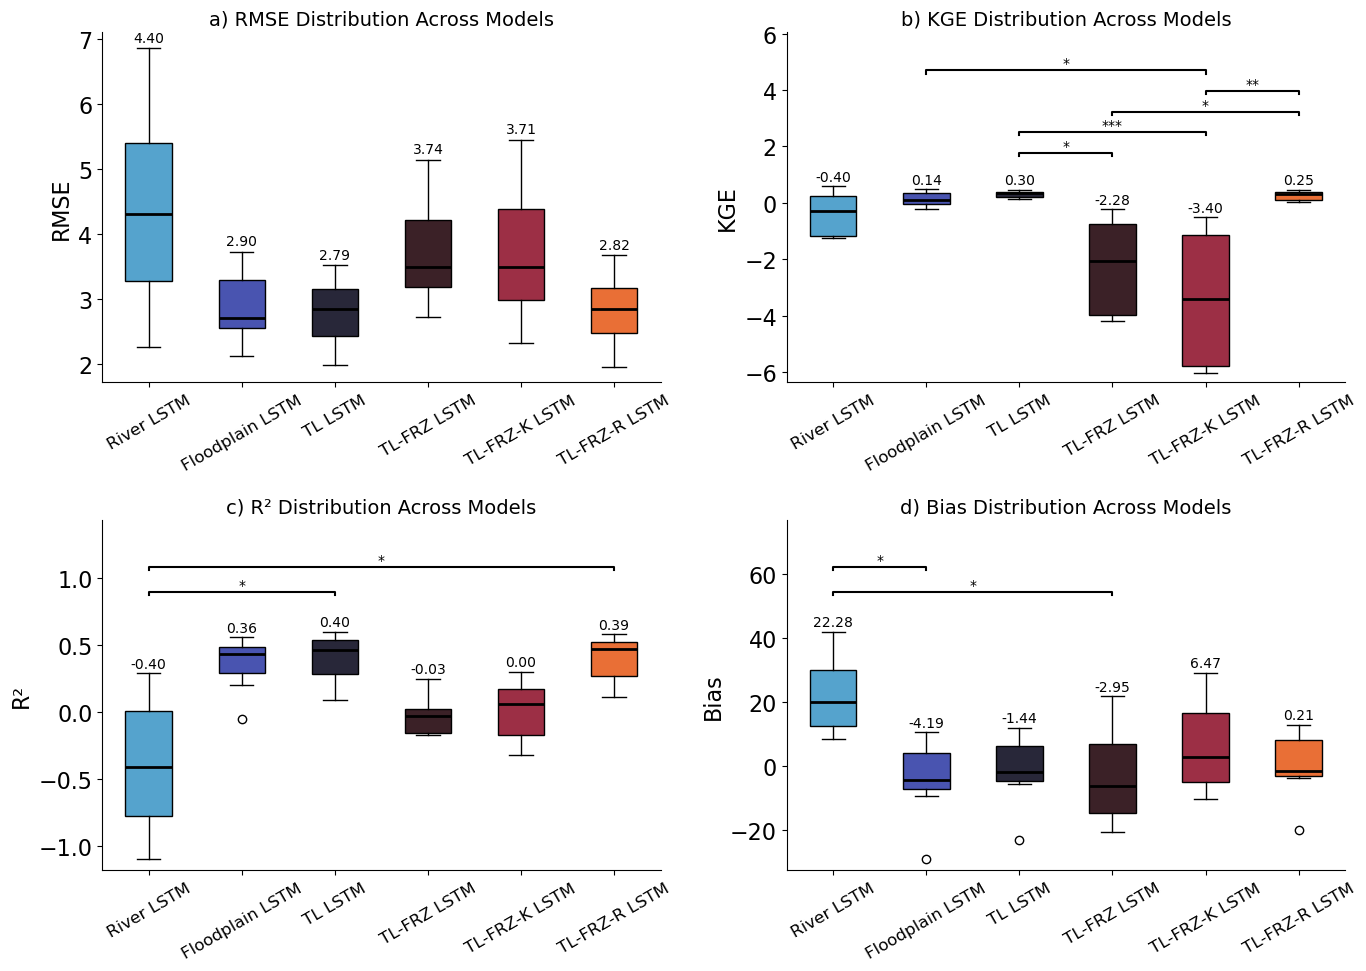

In [89]:
figpath = os.path.join(FIGURE_DIR, 'boxplots', 'model_performance_significance_TL_models.png')
boxplot_model_performance_with_significance_TL_models(results_df, stats_df, figpath)

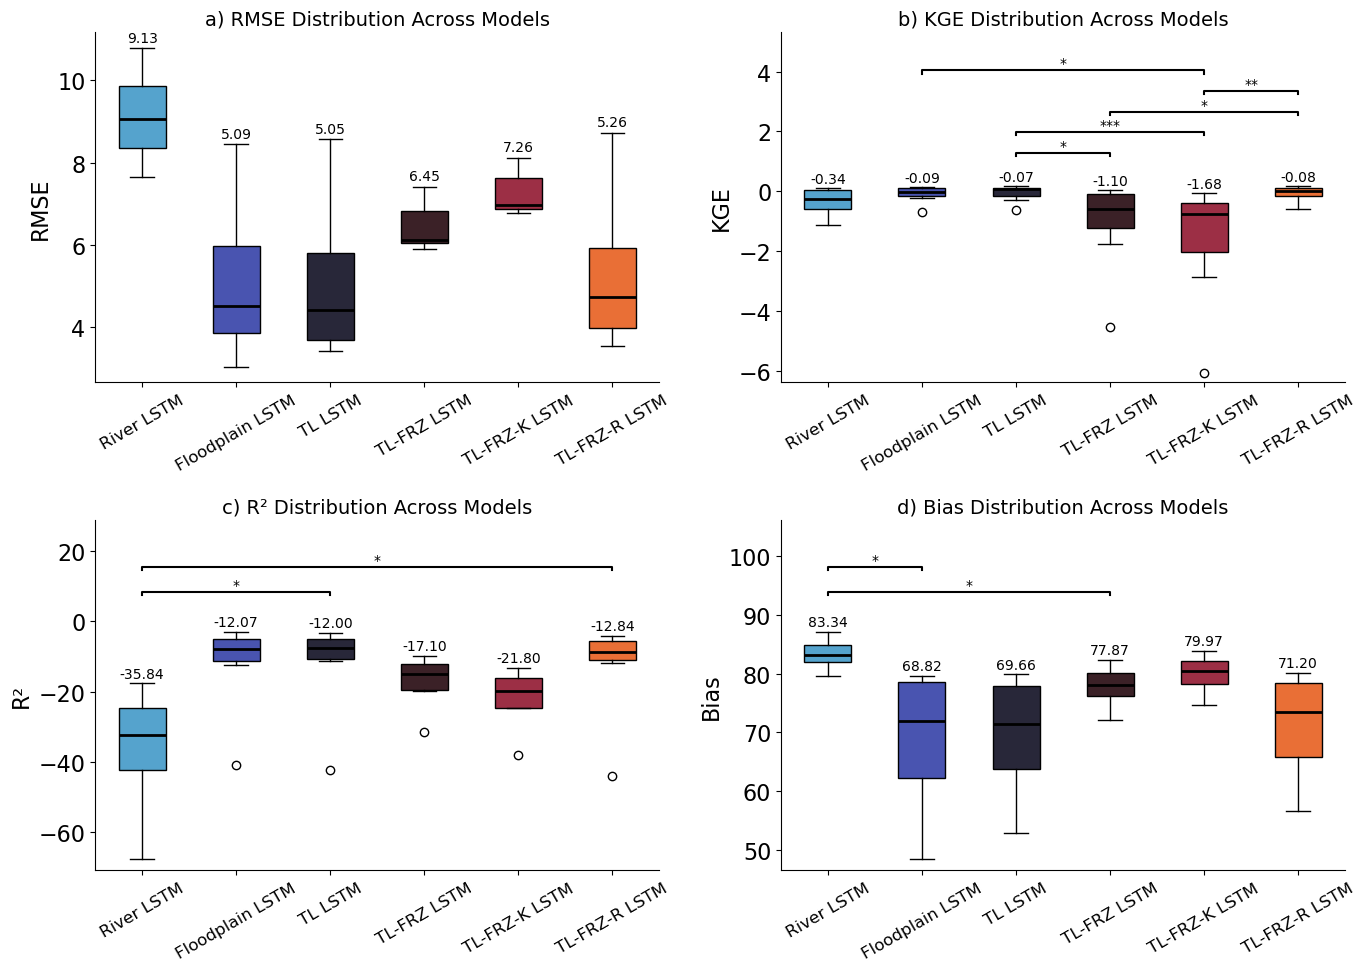

In [90]:
figpath = os.path.join(FIGURE_DIR, 'boxplots', 'model_performance_significance_low_TL_models.png')
boxplot_model_performance_with_significance_TL_models(results_df_low, stats_df, figpath)

### Plot all model predictions

In [74]:
def plot_all_result_sites(y_true, y_preds_PT, y_preds_FT, y_preds_FT_FRZ, y_preds_FT_FRZ_KD, y_preds_FT_FRZ_RD, y_preds_FP, test_start, test_end, scaler, site_code, train=False, TL_only=False):
    # store dates
    dates = y_true.index
    test_start = dates[test_start]
    test_end = dates[test_end]
    
    # Convert to 1-D arrays and inverse tranform
    y_true -= 1e-7
    y_preds_PT -= 1e-7
    y_preds_FT -= 1e-7
    y_preds_FT_FRZ -= 1e-7
    y_preds_FT_FRZ_KD -= 1e-7
    y_preds_FT_FRZ_RD -= 1e-7
    y_preds_FP -= 1e-7
    
    actual = scaler.inverse_transform(np.array(y_true).flatten().reshape(-1, 1))
    predictions_PT = scaler.inverse_transform(np.array(y_preds_PT).flatten().reshape(-1, 1))
    predictions_FT = scaler.inverse_transform(np.array(y_preds_FT).flatten().reshape(-1, 1))
    predictions_FT_FRZ = scaler.inverse_transform(np.array(y_preds_FT_FRZ).flatten().reshape(-1, 1))
    predictions_FT_FRZ_KD = scaler.inverse_transform(np.array(y_preds_FT_FRZ_KD).flatten().reshape(-1, 1))
    predictions_FT_FRZ_RD = scaler.inverse_transform(np.array(y_preds_FT_FRZ_RD).flatten().reshape(-1, 1))
    predictions_FP = scaler.inverse_transform(np.array(y_preds_FP).flatten().reshape(-1, 1))
    
    # convert back to pandas series and index by date
    actual = pd.Series(actual.flatten(), index=dates, name='Actual')
    predictions_PT = pd.Series(predictions_PT.flatten(), index=dates, name='River LSTM Predictions')
    predictions_FT = pd.Series(predictions_FT.flatten(), index=dates, name='TL LSTM Predictions')
    predictions_FT_FRZ = pd.Series(predictions_FT_FRZ.flatten(), index=dates, name='TL-FRZ LSTM Predictions')
    predictions_FT_FRZ_KD = pd.Series(predictions_FT_FRZ_KD.flatten(), index=dates, name='TL-FRZ-K LSTM Predictions')
    predictions_FT_FRZ_RD = pd.Series(predictions_FT_FRZ_RD.flatten(), index=dates, name='TL-FRZ-R LSTM Predictions')
    predictions_FP = pd.Series(predictions_FP.flatten(), index=dates, name='Floodplain LSTM Predictions')
    actual = actual.asfreq('D')
    predictions_PT = predictions_PT.asfreq('D')
    predictions_FT = predictions_FT.asfreq('D')
    predictions_FT_FRZ = predictions_FT_FRZ.asfreq('D')
    predictions_FT_FRZ_KD = predictions_FT_FRZ_KD.asfreq('D')
    predictions_FT_FRZ_RD = predictions_FT_FRZ_RD.asfreq('D')
    predictions_FP = predictions_FP.asfreq('D')
    
    # Plot predictions
    fig, ax1 = plt.subplots(figsize=(15, 6))
    plt.rcParams.update({'font.size': 16})
    colors = sns.color_palette("icefire")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DO (mg/L)')
    if TL_only:
        ax1.plot(actual, label='Actual', color='#7f7f7f')
        ax1.plot(predictions_FT, label='TL LSTM Predictions', color=colors[2])
        ax1.plot(predictions_FT_FRZ, label='TL-FRZ LSTM Predictions', color=colors[3])
        ax1.plot(predictions_FT_FRZ_KD, label='TL-FRZ-KD LSTM Predictions', color=colors[4])
        ax1.plot(predictions_FT_FRZ_RD, label='TL-FRZ-RD LSTM Predictions', color=colors[5])
        
        if train:
            plt.axvline(x=test_start, color='black', linestyle="--", label="Train/Test Split")
            plt.axvline(x=test_end, color='black', linestyle="--")
            
        fig.subplots_adjust(right=0.80)      # values <1 move the right border left
        legend = fig.legend(loc="lower center", bbox_to_anchor=(0.45, -0.1), fontsize=12, borderaxespad=0, ncol=3)
        plt.title(f'{site_code} Actual and Predicted DO Values', pad=10)
        # plt.tight_layout()
        plt.savefig(FIGURE_DIR + f'/predictions/TL_only/{site_code}_TL_only_model_predictions.png', dpi=600,
                    bbox_inches='tight', bbox_extra_artists=[legend])
        plt.show()
    else:
        ax1.plot(actual, label='Actual', color='#7f7f7f')
        ax1.plot(predictions_PT, label='River LSTM Predictions', color=colors[0])
        ax1.plot(predictions_FP, label='Floodplain LSTM Predictions', color=colors[1])
        ax1.plot(predictions_FT, label='TL LSTM Predictions', color=colors[2])
        # ax1.plot(predictions_FT_FRZ, label='TL-FRZ LSTM Predictions', color=colors[4])
        # ax1.plot(predictions_FT_FRZ_KD, label='TL-FRZ-KD LSTM Predictions', color=colors[5])
        # ax1.plot(predictions_FT_FRZ_RD, label='TL-FRZ-R LSTM Predictions', color=colors[5])
        if train:
            plt.axvline(x=test_start, color='black', linestyle="--", label="Train/Test Split")
            plt.axvline(x=test_end, color='black', linestyle="--")
            
        fig.subplots_adjust(right=0.80)      # values <1 move the right border left
        legend = fig.legend(loc="lower center", bbox_to_anchor=(0.45, -0.1), fontsize=12, borderaxespad=0, ncol=3)
        plt.title(f'{site_code} Actual and Predicted DO Values', pad=10)
        # plt.tight_layout()
        
        plt.savefig(FIGURE_DIR + f'/predictions/{site_code}_model_predictions.png', dpi=600,
                    bbox_inches="tight", bbox_extra_artists=[legend])
        plt.show()


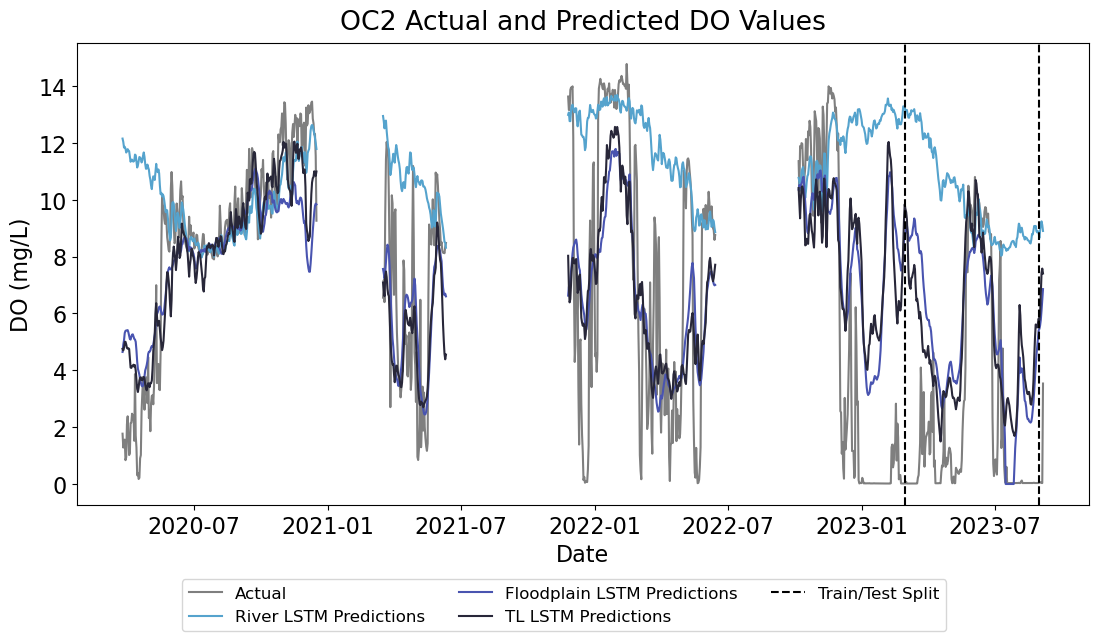

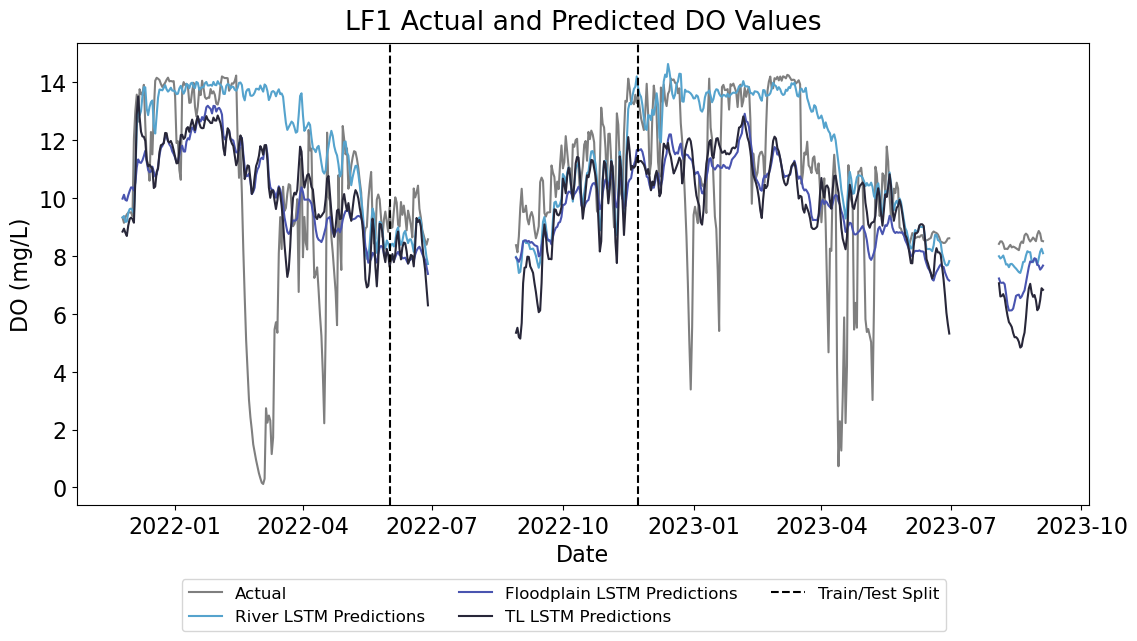

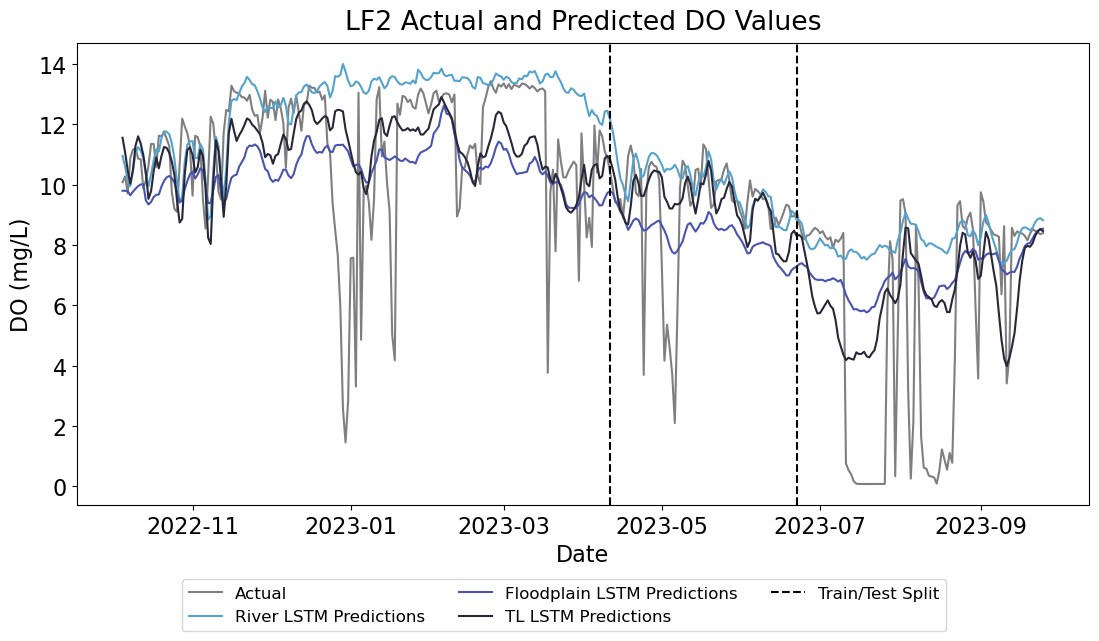

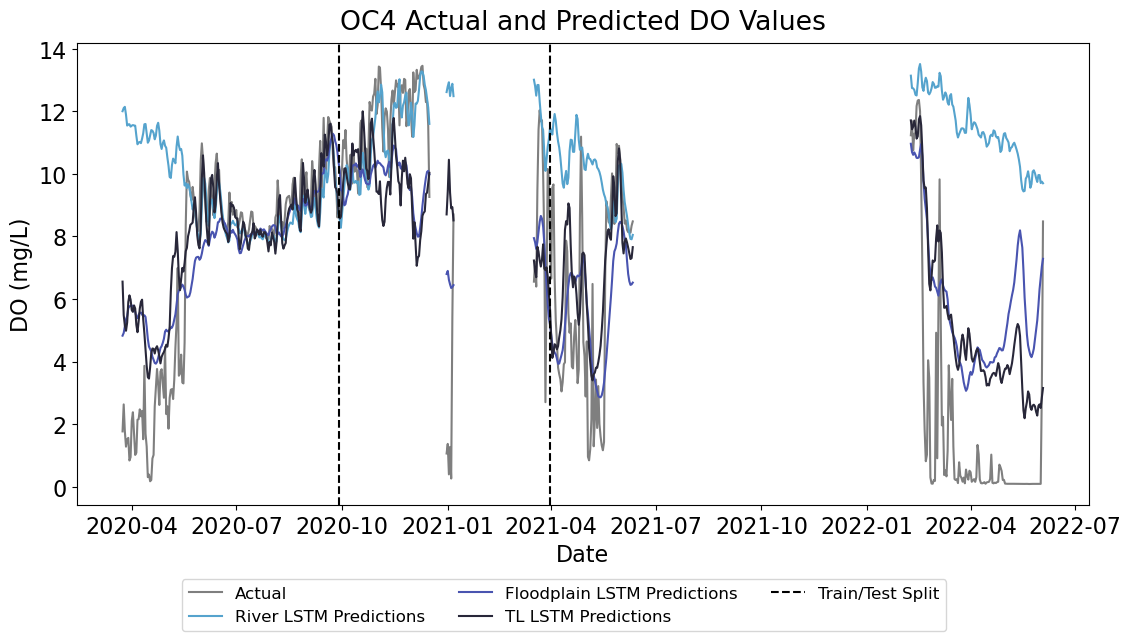

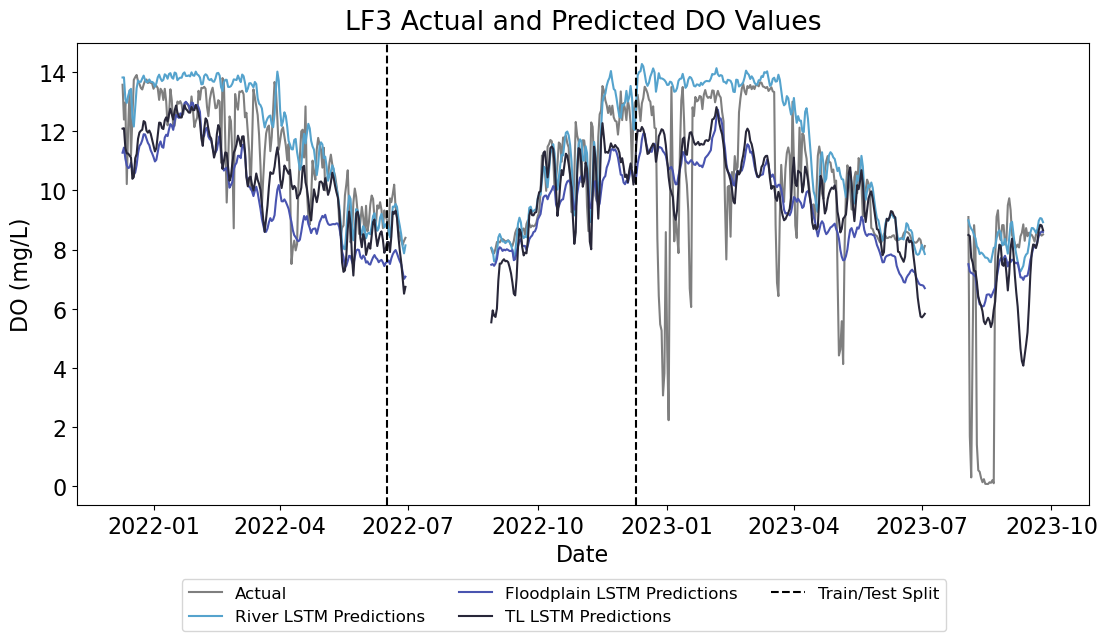

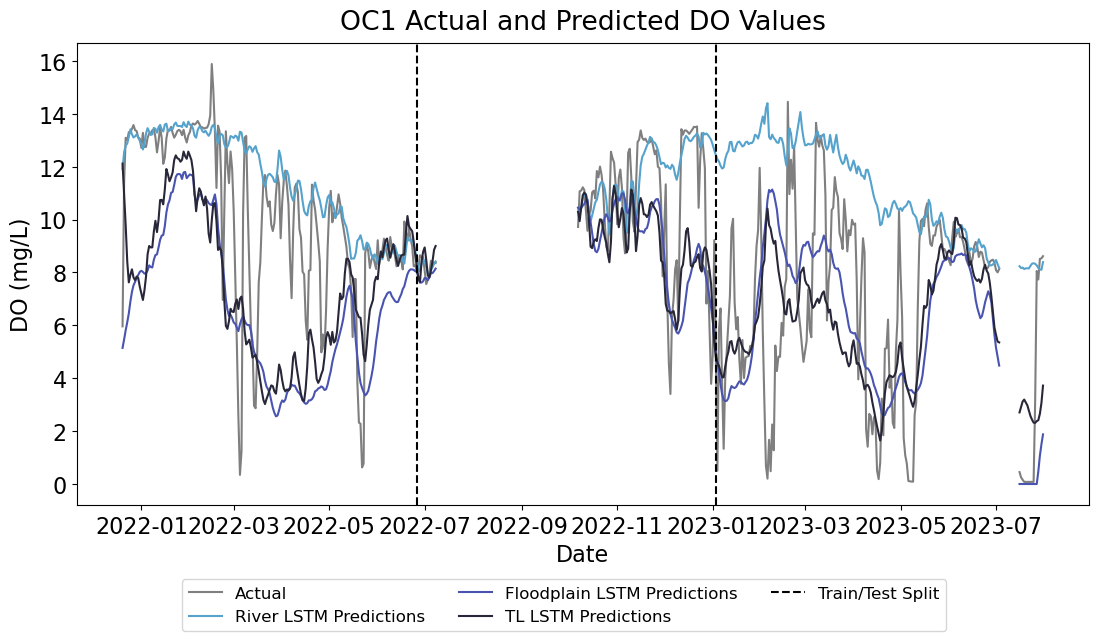

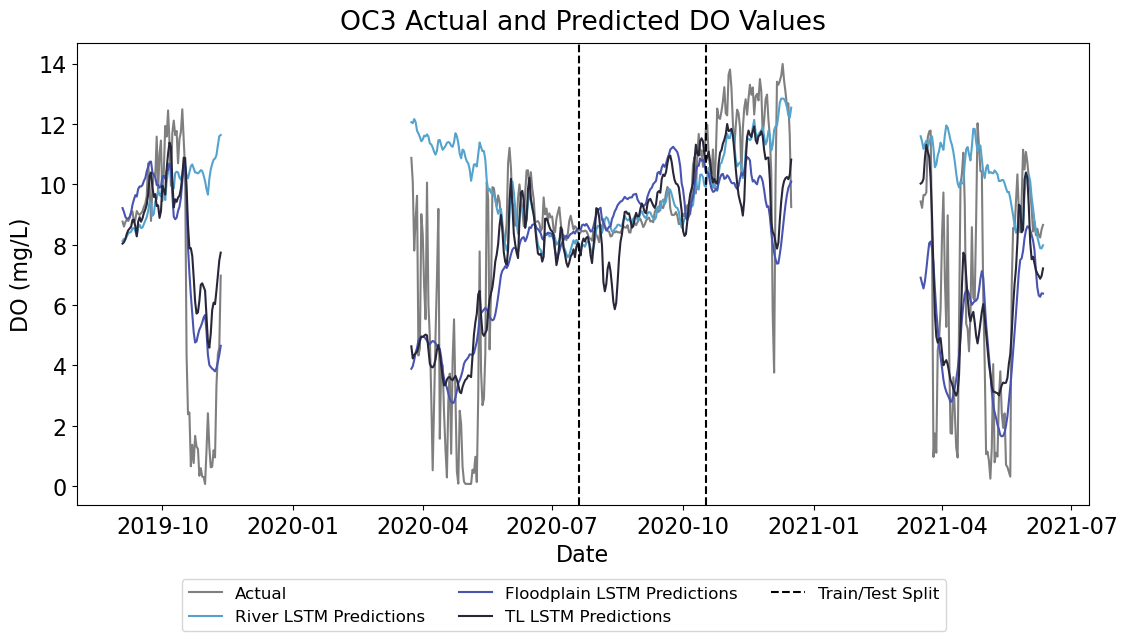

In [75]:
plot_all_result_sites(y_OC2, OC2_preds_PT, OC2_preds, OC2_preds_FRZ, OC2_preds_FRZ_KD, OC2_preds_FRZ_RD, OC2_preds_FP, OC2_start, OC2_end, scaler_y, "OC2", train=True)
plot_all_result_sites(y_LF1, LF1_preds_PT, LF1_preds, LF1_preds_FRZ, LF1_preds_FRZ_KD, LF1_preds_FRZ_RD, LF1_preds_FP, LF1_start, LF1_end, scaler_y, "LF1", train=True)
plot_all_result_sites(y_LF2, LF2_preds_PT, LF2_preds, LF2_preds_FRZ, LF2_preds_FRZ_KD, LF2_preds_FRZ_RD, LF2_preds_FP, LF2_start, LF2_end, scaler_y, "LF2", train=True)
plot_all_result_sites(y_OC4, OC4_preds_PT, OC4_preds, OC4_preds_FRZ, OC4_preds_FRZ_KD, OC4_preds_FRZ_RD, OC4_preds_FP, OC4_start, OC4_end, scaler_y, "OC4", train=True)
plot_all_result_sites(y_LF3, LF3_preds_PT, LF3_preds, LF3_preds_FRZ, LF3_preds_FRZ_KD, LF3_preds_FRZ_RD, LF3_preds_FP, LF3_start, LF3_end, scaler_y, "LF3", train=True)
plot_all_result_sites(y_OC1, OC1_preds_PT, OC1_preds, OC1_preds_FRZ, OC1_preds_FRZ_KD, OC1_preds_FRZ_RD, OC1_preds_FP, OC1_start, OC1_end, scaler_y, "OC1", train=True)
plot_all_result_sites(y_OC3, OC3_preds_PT, OC3_preds, OC3_preds_FRZ, OC3_preds_FRZ_KD, OC3_preds_FRZ_RD, OC3_preds_FP, OC3_start, OC3_end, scaler_y, "OC3", train=True)

### Only TL model predictions 

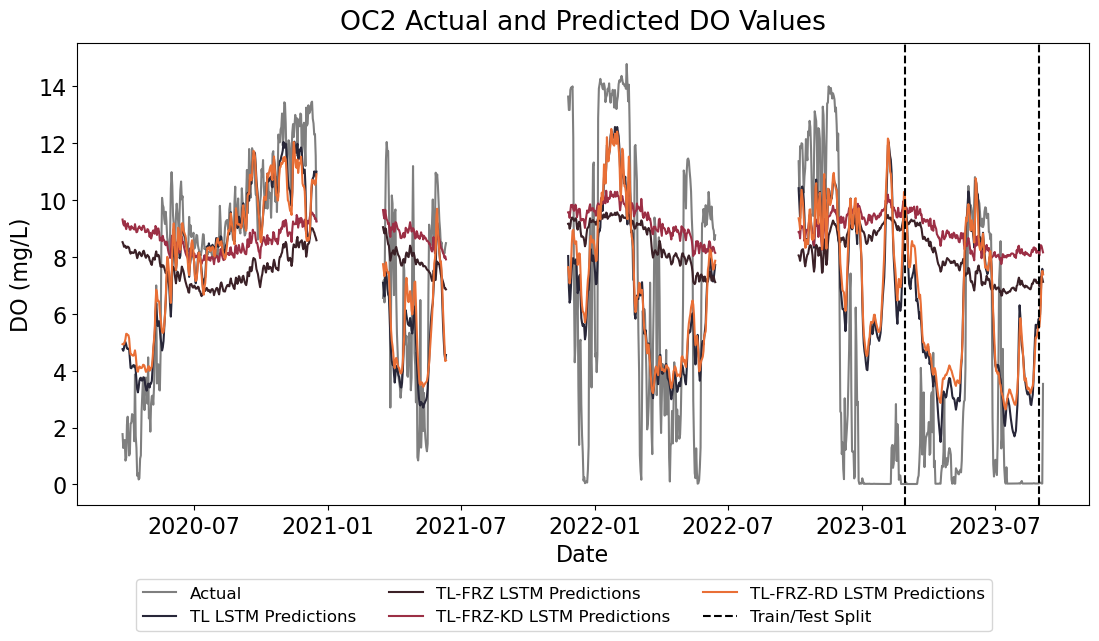

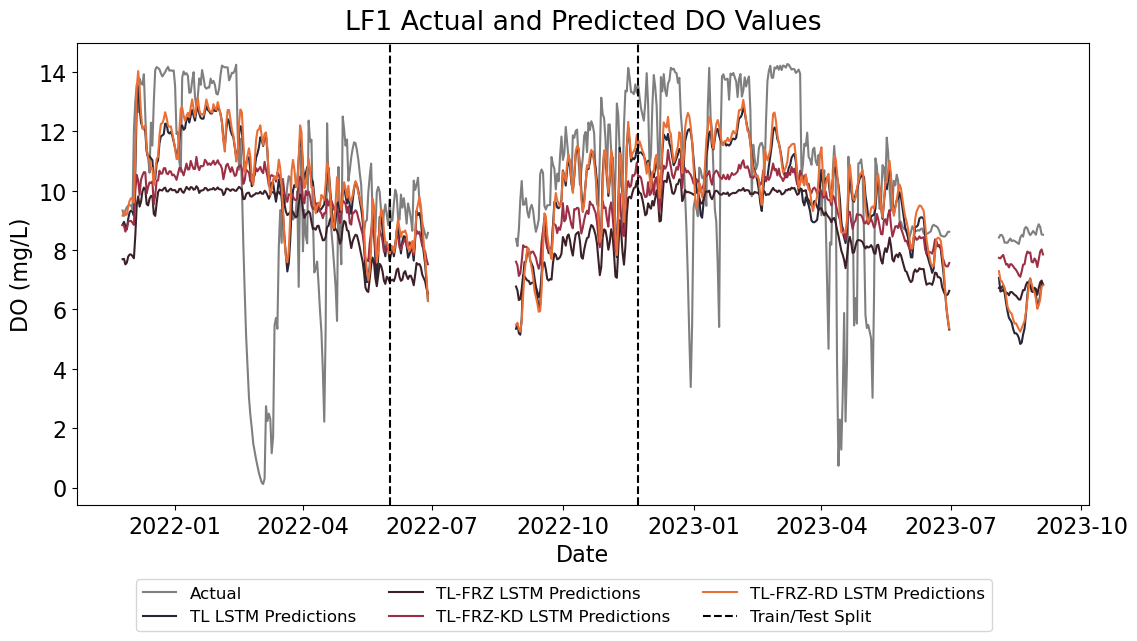

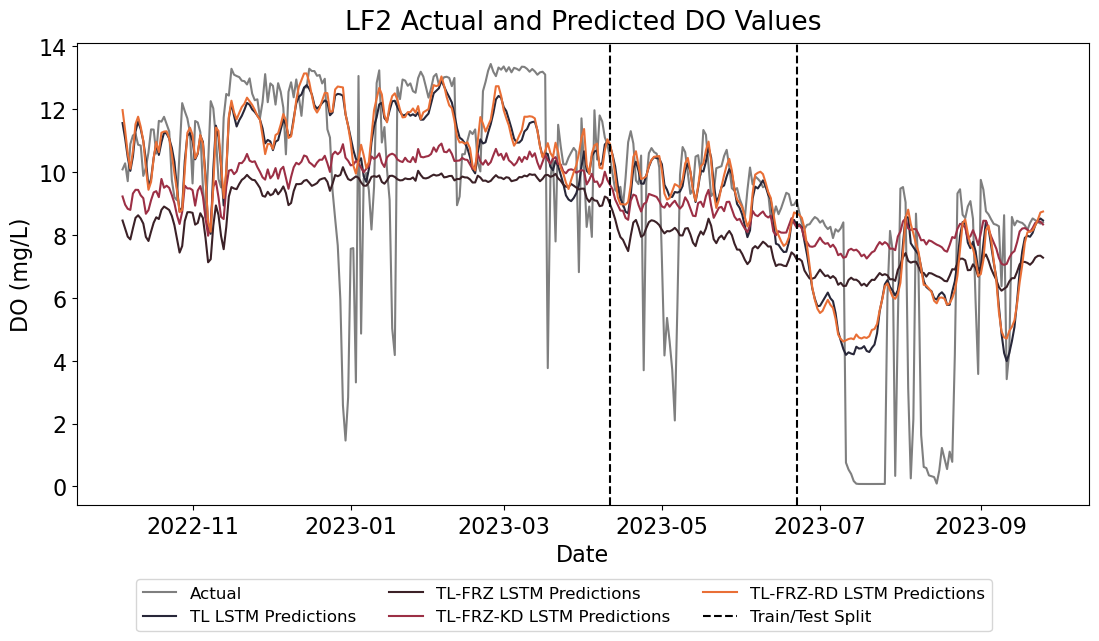

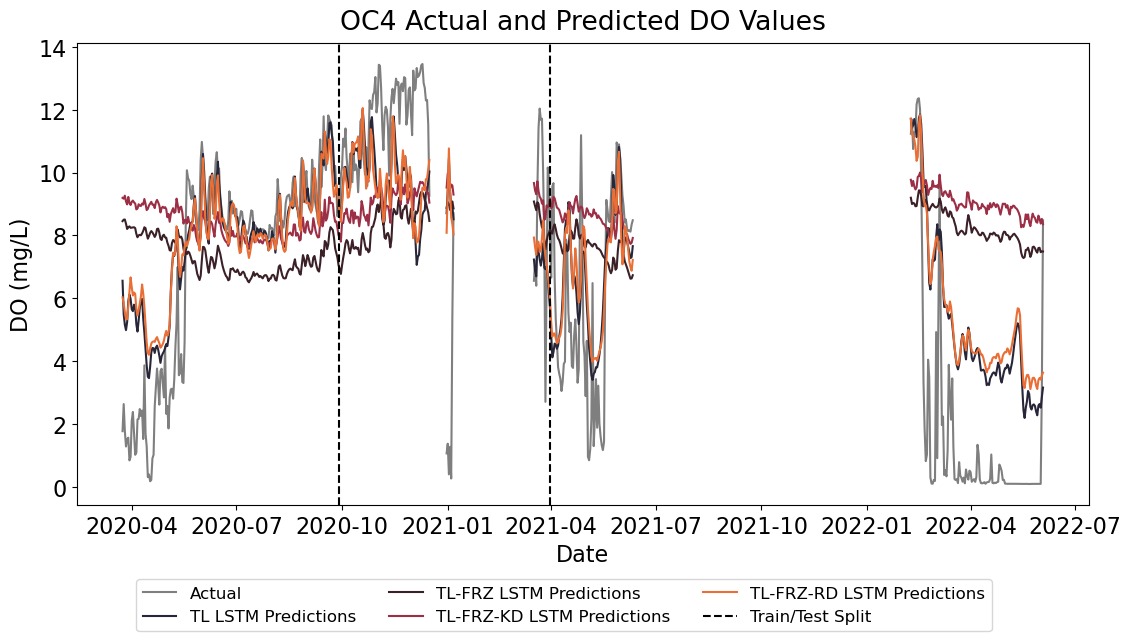

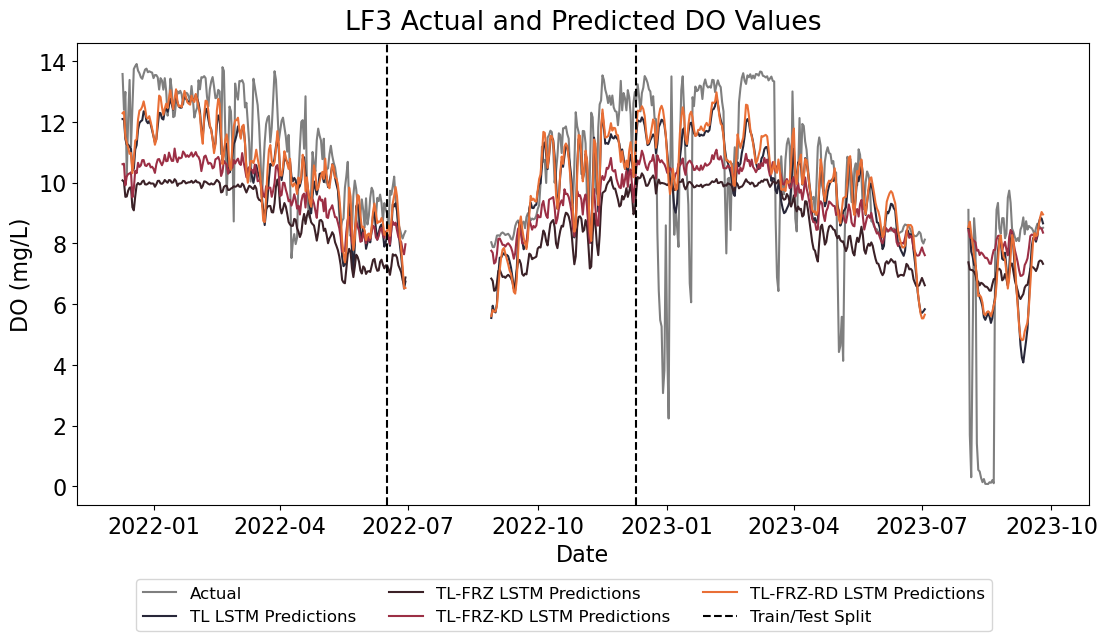

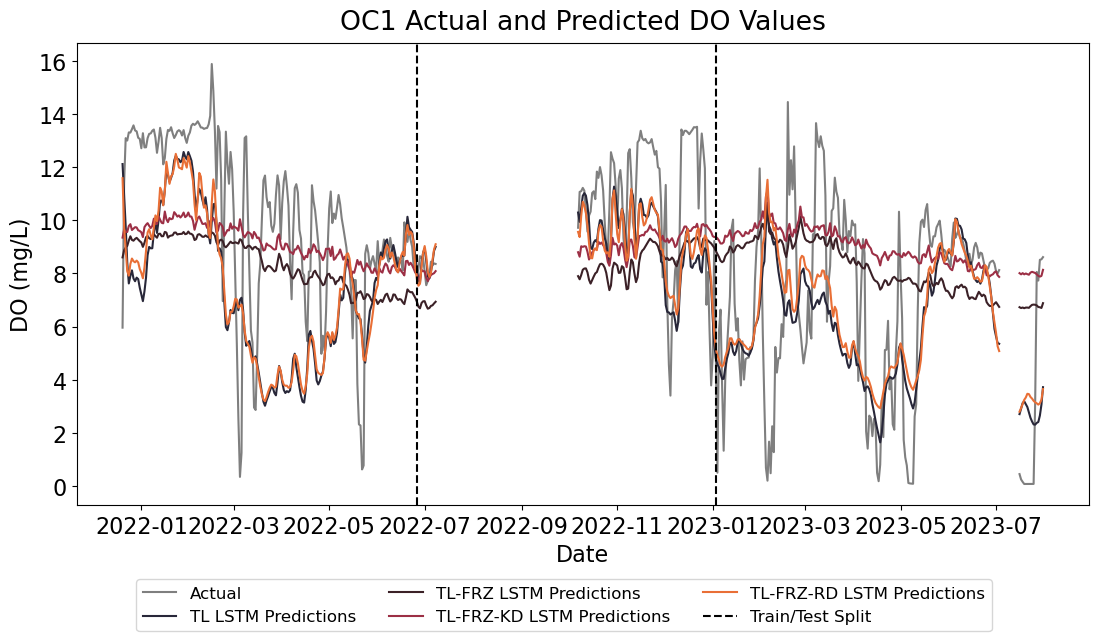

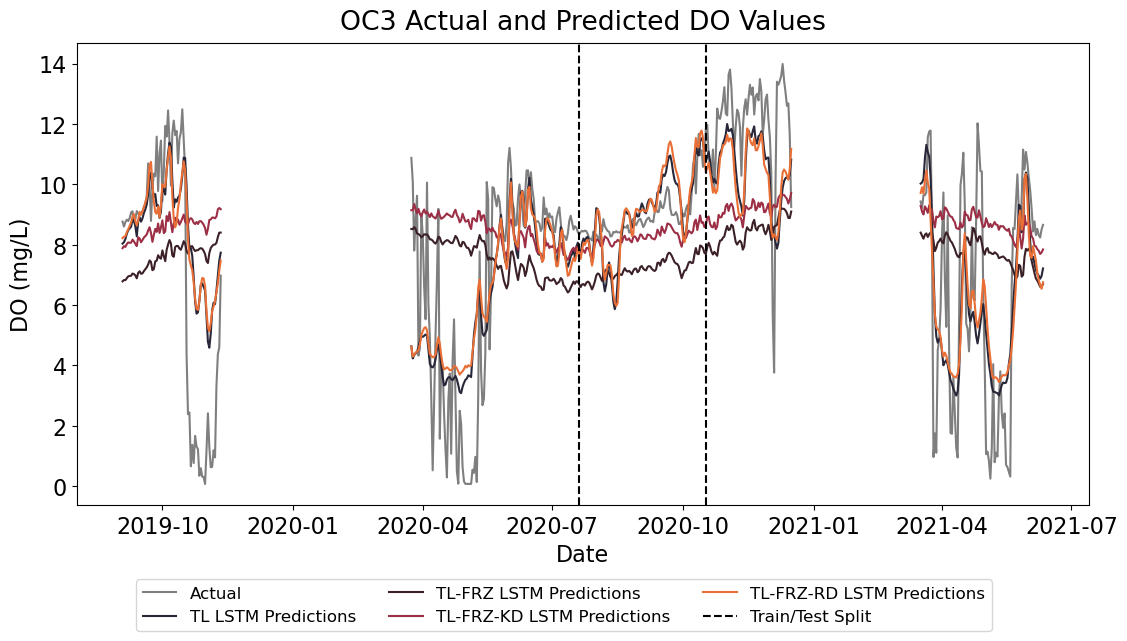

In [76]:
plot_all_result_sites(y_OC2, OC2_preds_PT, OC2_preds, OC2_preds_FRZ, OC2_preds_FRZ_KD, OC2_preds_FRZ_RD, OC2_preds_FP, OC2_start, OC2_end, scaler_y, "OC2", train=True, TL_only=True)
plot_all_result_sites(y_LF1, LF1_preds_PT, LF1_preds, LF1_preds_FRZ, LF1_preds_FRZ_KD, LF1_preds_FRZ_RD, LF1_preds_FP, LF1_start, LF1_end, scaler_y, "LF1", train=True, TL_only=True)
plot_all_result_sites(y_LF2, LF2_preds_PT, LF2_preds, LF2_preds_FRZ, LF2_preds_FRZ_KD, LF2_preds_FRZ_RD, LF2_preds_FP, LF2_start, LF2_end, scaler_y, "LF2", train=True, TL_only=True)
plot_all_result_sites(y_OC4, OC4_preds_PT, OC4_preds, OC4_preds_FRZ, OC4_preds_FRZ_KD, OC4_preds_FRZ_RD, OC4_preds_FP, OC4_start, OC4_end, scaler_y, "OC4", train=True, TL_only=True)
plot_all_result_sites(y_LF3, LF3_preds_PT, LF3_preds, LF3_preds_FRZ, LF3_preds_FRZ_KD, LF3_preds_FRZ_RD, LF3_preds_FP, LF3_start, LF3_end, scaler_y, "LF3", train=True, TL_only=True)
plot_all_result_sites(y_OC1, OC1_preds_PT, OC1_preds, OC1_preds_FRZ, OC1_preds_FRZ_KD, OC1_preds_FRZ_RD, OC1_preds_FP, OC1_start, OC1_end, scaler_y, "OC1", train=True, TL_only=True)
plot_all_result_sites(y_OC3, OC3_preds_PT, OC3_preds, OC3_preds_FRZ, OC3_preds_FRZ_KD, OC3_preds_FRZ_RD, OC3_preds_FP, OC3_start, OC3_end, scaler_y, "OC3", train=True, TL_only=True)